# Setup

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import calendar

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

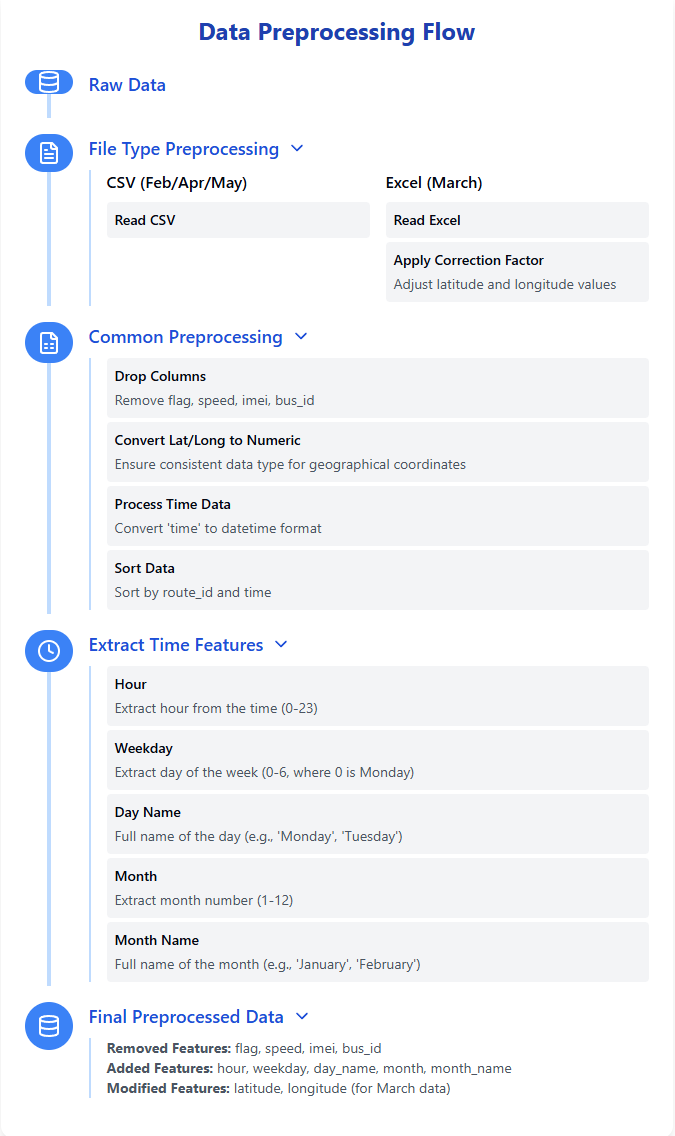

In [2]:
def load_and_prepare_data(file_path, file_type='csv', correction_factor=None):
    # Load data
    if file_type == 'csv':
        df = pd.read_csv(file_path)
    elif file_type == 'excel':
        df = pd.read_excel(file_path)

    # Drop unnecessary columns
    df.drop(['flag', 'speed', 'imei', 'bus_id'], axis=1, inplace=True)

    # Convert latitude and longitude to numeric, handling different possible formats
    def convert_to_numeric(x):
        if isinstance(x, (int, float)):
            return x
        elif isinstance(x, str):
            return pd.to_numeric(x.replace(',', '.'), errors='coerce')
        else:
            return np.nan

    df['latitude'] = df['latitude'].apply(convert_to_numeric)
    df['longitude'] = df['longitude'].apply(convert_to_numeric)

    # Correct latitude and longitude if needed
    if correction_factor:
        df['latitude'] = df['latitude'] / correction_factor
        df['longitude'] = df['longitude'] / correction_factor

    # Convert 'time' to datetime and sort data
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df.sort_values(by=['route_id', 'time'], inplace=True)

    # Extract time-related features
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.weekday
    df['day_name'] = df['time'].dt.day_name()
    df['month'] = df['time'].dt.month
    
    # Apply a lambda function to convert month numbers to names
    df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])

    return df

# Load and prepare data for each month
# Get project root directory
project_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
data_dir = os.path.join(project_dir, 'data', 'raw')

feb_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_Feb2024.csv'), file_type='csv')
march_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_Mar2024.csv'), file_type='csv')
april_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_Apr2024.csv'), file_type='csv')
may_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_May2024.csv'), file_type='csv')
june_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_June2024.csv'), file_type='csv')
july_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_July2024.csv'), file_type='csv')
august_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_Aug2024.csv'), file_type='csv')
september_df = load_and_prepare_data(os.path.join(data_dir, 'location_data_Sep2024.csv'), file_type='csv')


In [3]:
# Get length for each DataFrame
feb_length = len(feb_df)
march_length = len(march_df)
april_length = len(april_df)
may_length = len(may_df)
june_length = len(june_df)
july_length = len(july_df)
august_length = len(august_df)
september_length = len(september_df)

# Print lengths
print(f"February DataFrame length: {feb_length}")
print(f"March DataFrame length: {march_length}")
print(f"April DataFrame length: {april_length}")
print(f"May DataFrame length: {may_length}")
print(f"June DataFrame length: {june_length}")
print(f"July DataFrame length: {july_length}")
print(f"August DataFrame length: {august_length}")
print(f"September DataFrame length: {september_length}")


February DataFrame length: 804
March DataFrame length: 464
April DataFrame length: 330
May DataFrame length: 580
June DataFrame length: 302
July DataFrame length: 313
August DataFrame length: 846
September DataFrame length: 585


## merging the data

In [4]:
# Concatenate the three DataFrames
merged_df = pd.concat([feb_df, march_df, april_df, may_df, june_df, july_df, august_df, september_df])

# Reset the index to ensure it's sequential
merged_df.reset_index(drop=True, inplace=True)

## Estimating expected records based on holidays

In [6]:
from datetime import datetime

# Define school calendar data
school_calendar = {
    "school_days_per_month": {
        "February": 20,
        "March": 16,
        "April": 16,
        "May": 20,
        "June": 15,
        "July": 13,
        "August": 22,
        "September": 20
    },
    "holiday_dates": {
        "February": [4, 8, 10, 11, 18, 25],
        "March": [3, 10, 11, 12, 13, 14, 17, 24, 29, 31],
        "April": [7, 10, 11, 12, 13, 14, 15, 16, 17, 21, 28],
        "May": [1, 5, 9, 12, 19, 23, 25],
        "June": [1, 2, 9, 16, 23, 30],
        "July": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 28],
        "August": [4, 11, 17, 18, 25],
        "September": [1, 8, 15, 16, 22, 25]
    }
}

# Convert holiday dates to datetime objects for filtering
holiday_dates = []
for month, dates in school_calendar["holiday_dates"].items():
    for day in dates:
        holiday_dates.append(datetime(2024, datetime.strptime(month, '%B').month, day))

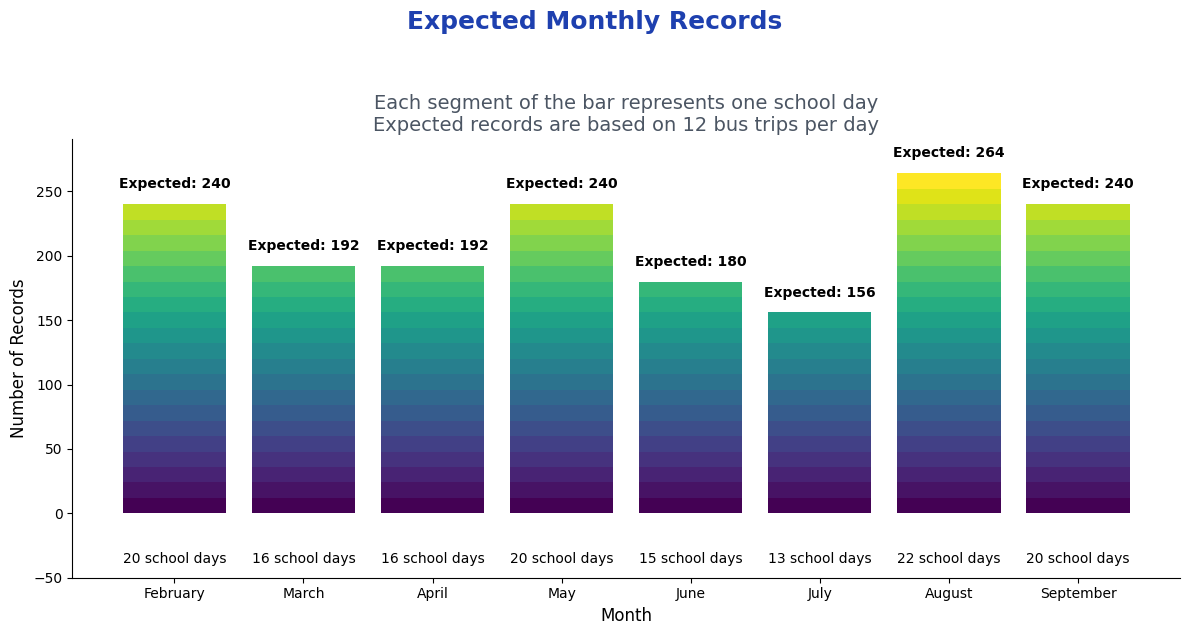

In [7]:
def plot_expected_monthly_records(school_calendar):
    """
    Creates a stacked bar chart showing expected monthly records based on school calendar data.
    
    Args:
        school_calendar (dict): Dictionary containing school_days_per_month and holiday_dates
    """
    # Create a DataFrame with the monthly data from school calendar
    data = pd.DataFrame({
        'month': list(school_calendar['school_days_per_month'].keys()),
        'days': [school_calendar['school_days_per_month'][m] for m in school_calendar['school_days_per_month'].keys()],
        'records': [school_calendar['school_days_per_month'][m] * 12 for m in school_calendar['school_days_per_month'].keys()]
    })

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define the colors for the stacks
    colors = plt.cm.viridis(np.linspace(0, 1, max(data['days'])))

    # Plot the stacked bar chart
    for idx, row in data.iterrows():
        bottom = 0
        for day in range(row['days']):
            ax.bar(row['month'], 12, bottom=bottom, color=colors[day])
            bottom += 12

    # Add multi-line title with enhanced styling
    plt.suptitle('Expected Monthly Records', fontsize=18, fontweight='bold', color='#1e40af', y=1.05)
    plt.title('Each segment of the bar represents one school day\nExpected records are based on 12 bus trips per day', 
              fontsize=14, color='#4b5563')

    # Customize the chart
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)

    # Add total records and school days as text labels
    for i, row in enumerate(data.itertuples()):
        plt.text(i, row.records + 10, f'Expected: {row.records:,}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.text(i, -30, f'{row.days} school days', ha='center', va='top', fontsize=10)

    # Adjust y-axis to make room for bottom text
    plt.ylim(-50, max(data['records']) * 1.1)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    return data

# Create the plot
monthly_data = plot_expected_monthly_records(school_calendar)


In [8]:
def plot_expected_vs_actual_records(monthly_data, filtered_df):
    """
    Create a bar chart comparing expected vs actual records by month.
    
    Args:
        monthly_data (pd.DataFrame): DataFrame containing expected records data
        filtered_df (pd.DataFrame): DataFrame containing actual records data
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get actual records per month
    actual_records = filtered_df.groupby(filtered_df['time'].dt.strftime('%B')).size()

    # Prepare data for plotting
    months = monthly_data['month']
    expected = monthly_data['records']
    actual = [actual_records.get(month, 0) for month in months]

    # Set width of bars
    bar_width = 0.35
    x = np.arange(len(months))

    # Create bars
    ax.bar(x - bar_width/2, expected, bar_width, label='Expected', color='#1e40af', alpha=0.7)
    ax.bar(x + bar_width/2, actual, bar_width, label='Actual', color='#22c55e', alpha=0.7)

    # Customize the chart
    plt.title('Expected vs Actual Records by Month', fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)

    # Set x-axis ticks
    plt.xticks(x, months)

    # Add value labels
    for i, (exp, act) in enumerate(zip(expected, actual)):
        # Label for expected records
        plt.text(i - bar_width/2, exp, f'{int(exp):,}', 
                ha='center', va='bottom', fontsize=10)
        # Label for actual records  
        plt.text(i + bar_width/2, act, f'{int(act):,}',
                ha='center', va='bottom', fontsize=10)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend()
    plt.tight_layout()
    plt.show()


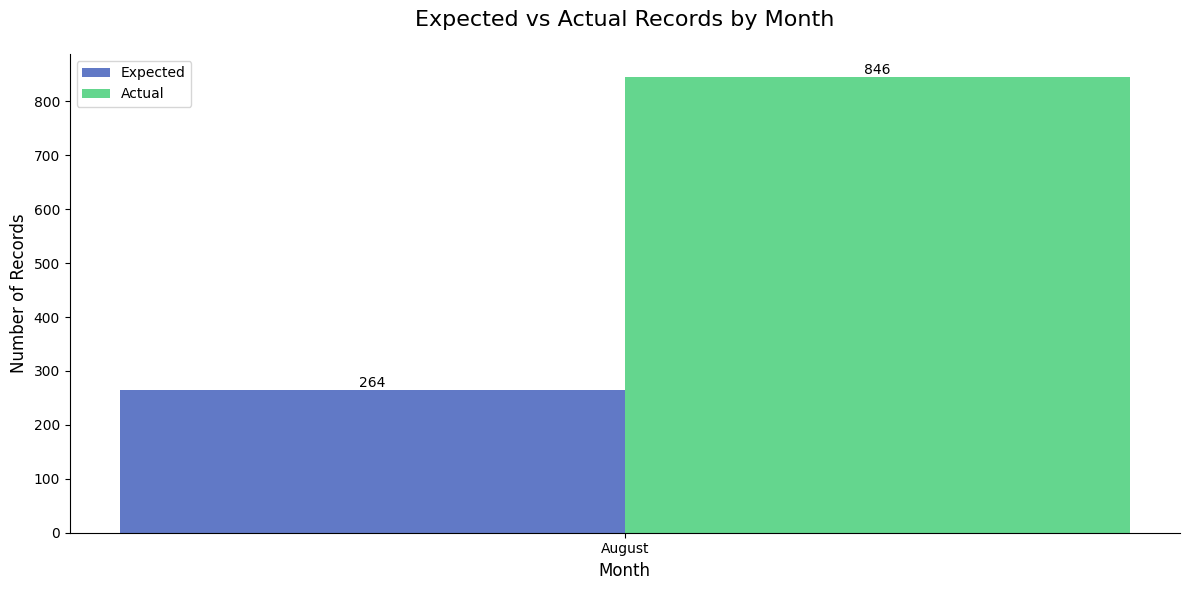

In [9]:
monthly_data_aug = monthly_data[monthly_data['month'] == 'August']
plot_expected_vs_actual_records(monthly_data_aug, merged_df)

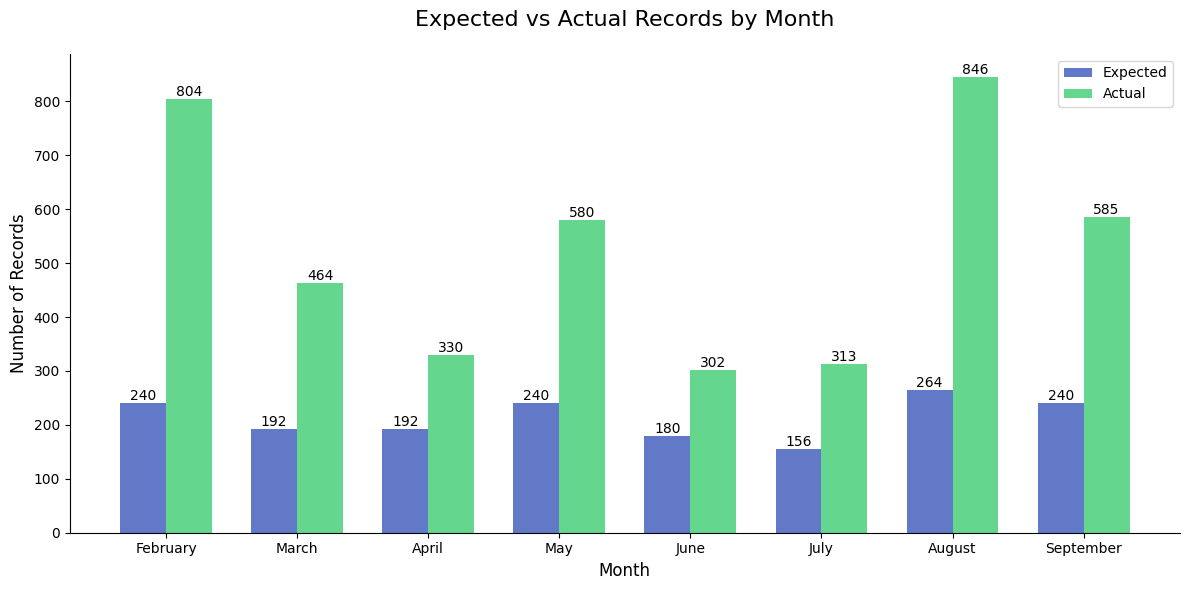

In [10]:
# Filter out August data
monthly_data_no_aug = monthly_data['month']
plot_expected_vs_actual_records(monthly_data, merged_df)

## exploring weekend data

In [24]:
def plot_monthly_records(df, title='Number of Records by Month (Weekdays Only)'):
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Custom color palette
    colors = ['#2563eb']  # Modern blue
    
    # Count records
    monthly_counts = df.groupby('month_name').size().reindex(
        ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September'], 
        fill_value=0
    )

    # Create figure with higher DPI for better quality
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    
    # Create bars with custom styling
    bars = ax.bar(
        monthly_counts.index, 
        monthly_counts.values,
        color=colors,
        alpha=0.8,
        width=0.6
    )

    # Customize plot
    ax.set_title(title, fontsize=16, pad=20, fontweight='bold', color='#1e293b')
    ax.set_xlabel('Month', fontsize=12, color='#475569')
    ax.set_ylabel('Number of Records', fontsize=12, color='#475569')

    # Add value labels with improved styling
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., 
            height,
            f'{int(height):,}',  # Add thousand separator
            ha='center', 
            va='bottom',
            fontsize=10,
            color='#475569',
            fontweight='bold'
        )

    # Customize grid
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='#94a3b8')
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#94a3b8')
    ax.spines['bottom'].set_color('#94a3b8')

    # Customize ticks
    ax.tick_params(axis='both', colors='#475569')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_weekend_records(df, title='Number of Weekend Records by Month'):
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Custom color palette
    colors = ['#10b981']  # Modern green
    
    # Count weekend records
    weekend_counts = df[df['weekday'].isin([5, 6])].groupby('month_name').size().reindex(
        ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September'], 
        fill_value=0
    )

    # Create figure with higher DPI
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    
    # Create bars with custom styling
    bars = ax.bar(
        weekend_counts.index, 
        weekend_counts.values,
        color=colors,
        alpha=0.8,
        width=0.6
    )

    # Customize plot
    ax.set_title(title, fontsize=16, pad=20, fontweight='bold', color='#1e293b')
    ax.set_xlabel('Month', fontsize=12, color='#475569')
    ax.set_ylabel('Number of Records', fontsize=12, color='#475569')

    # Add value labels with improved styling
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., 
            height,
            f'{int(height):,}',  # Add thousand separator
            ha='center', 
            va='bottom',
            fontsize=10,
            color='#475569',
            fontweight='bold'
        )

    # Customize grid
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='#94a3b8')
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#94a3b8')
    ax.spines['bottom'].set_color('#94a3b8')

    # Customize ticks
    ax.tick_params(axis='both', colors='#475569')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

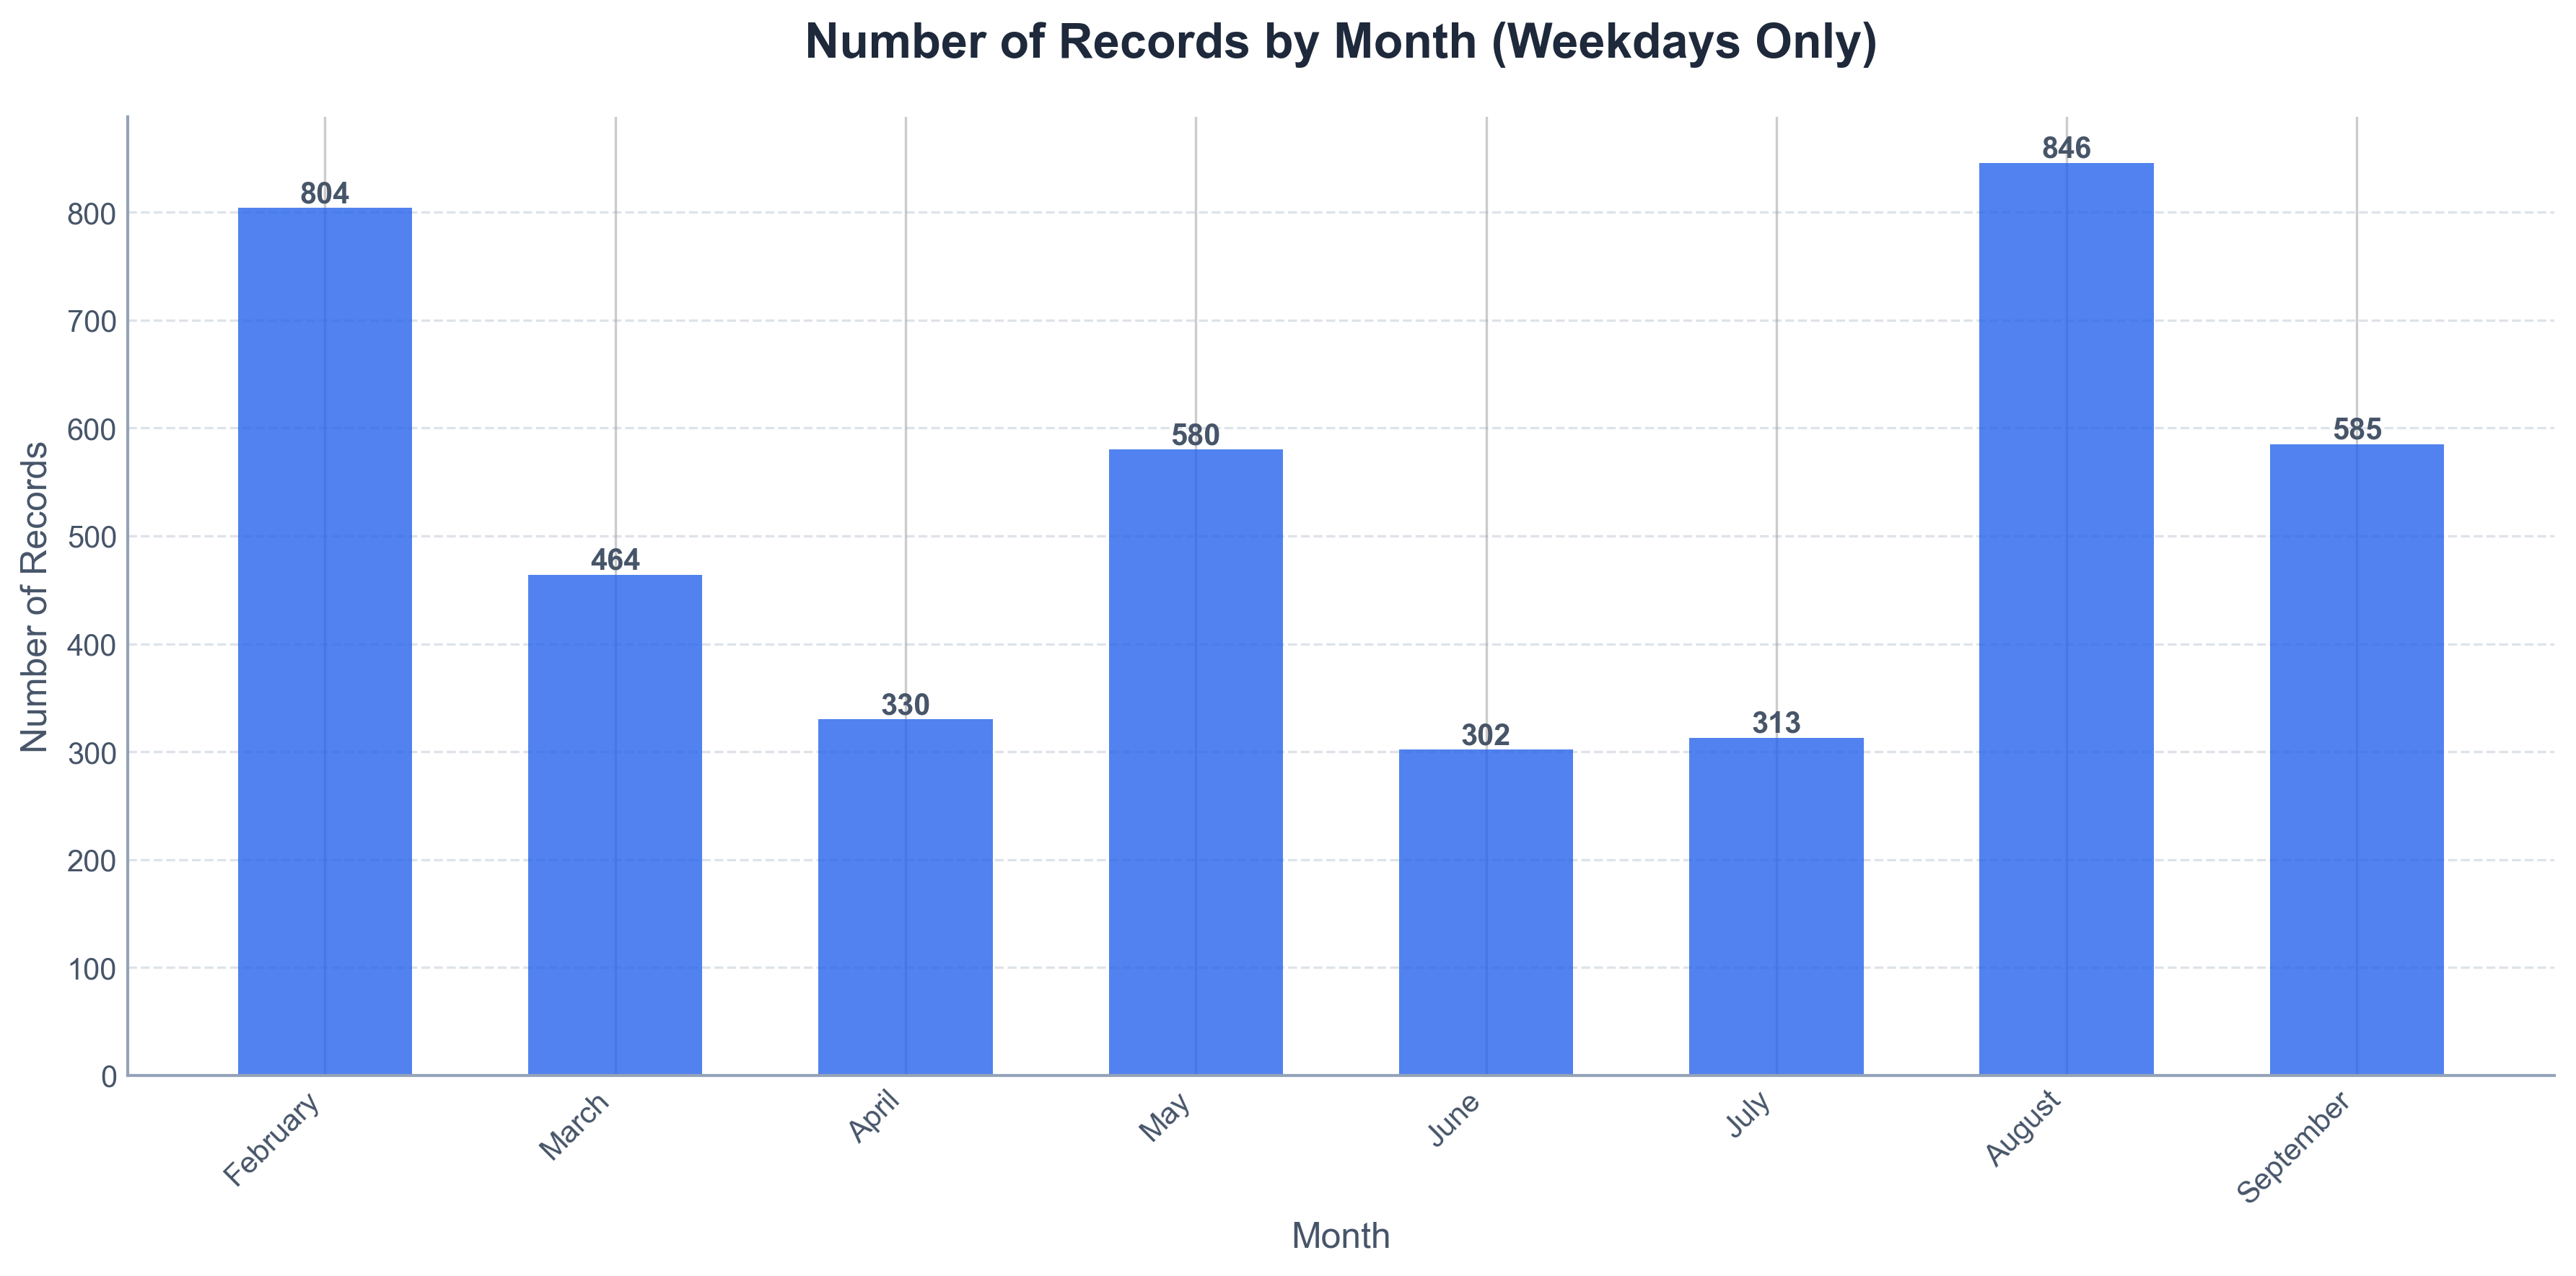

In [25]:
# Call function with merged_df
plot_monthly_records(merged_df)

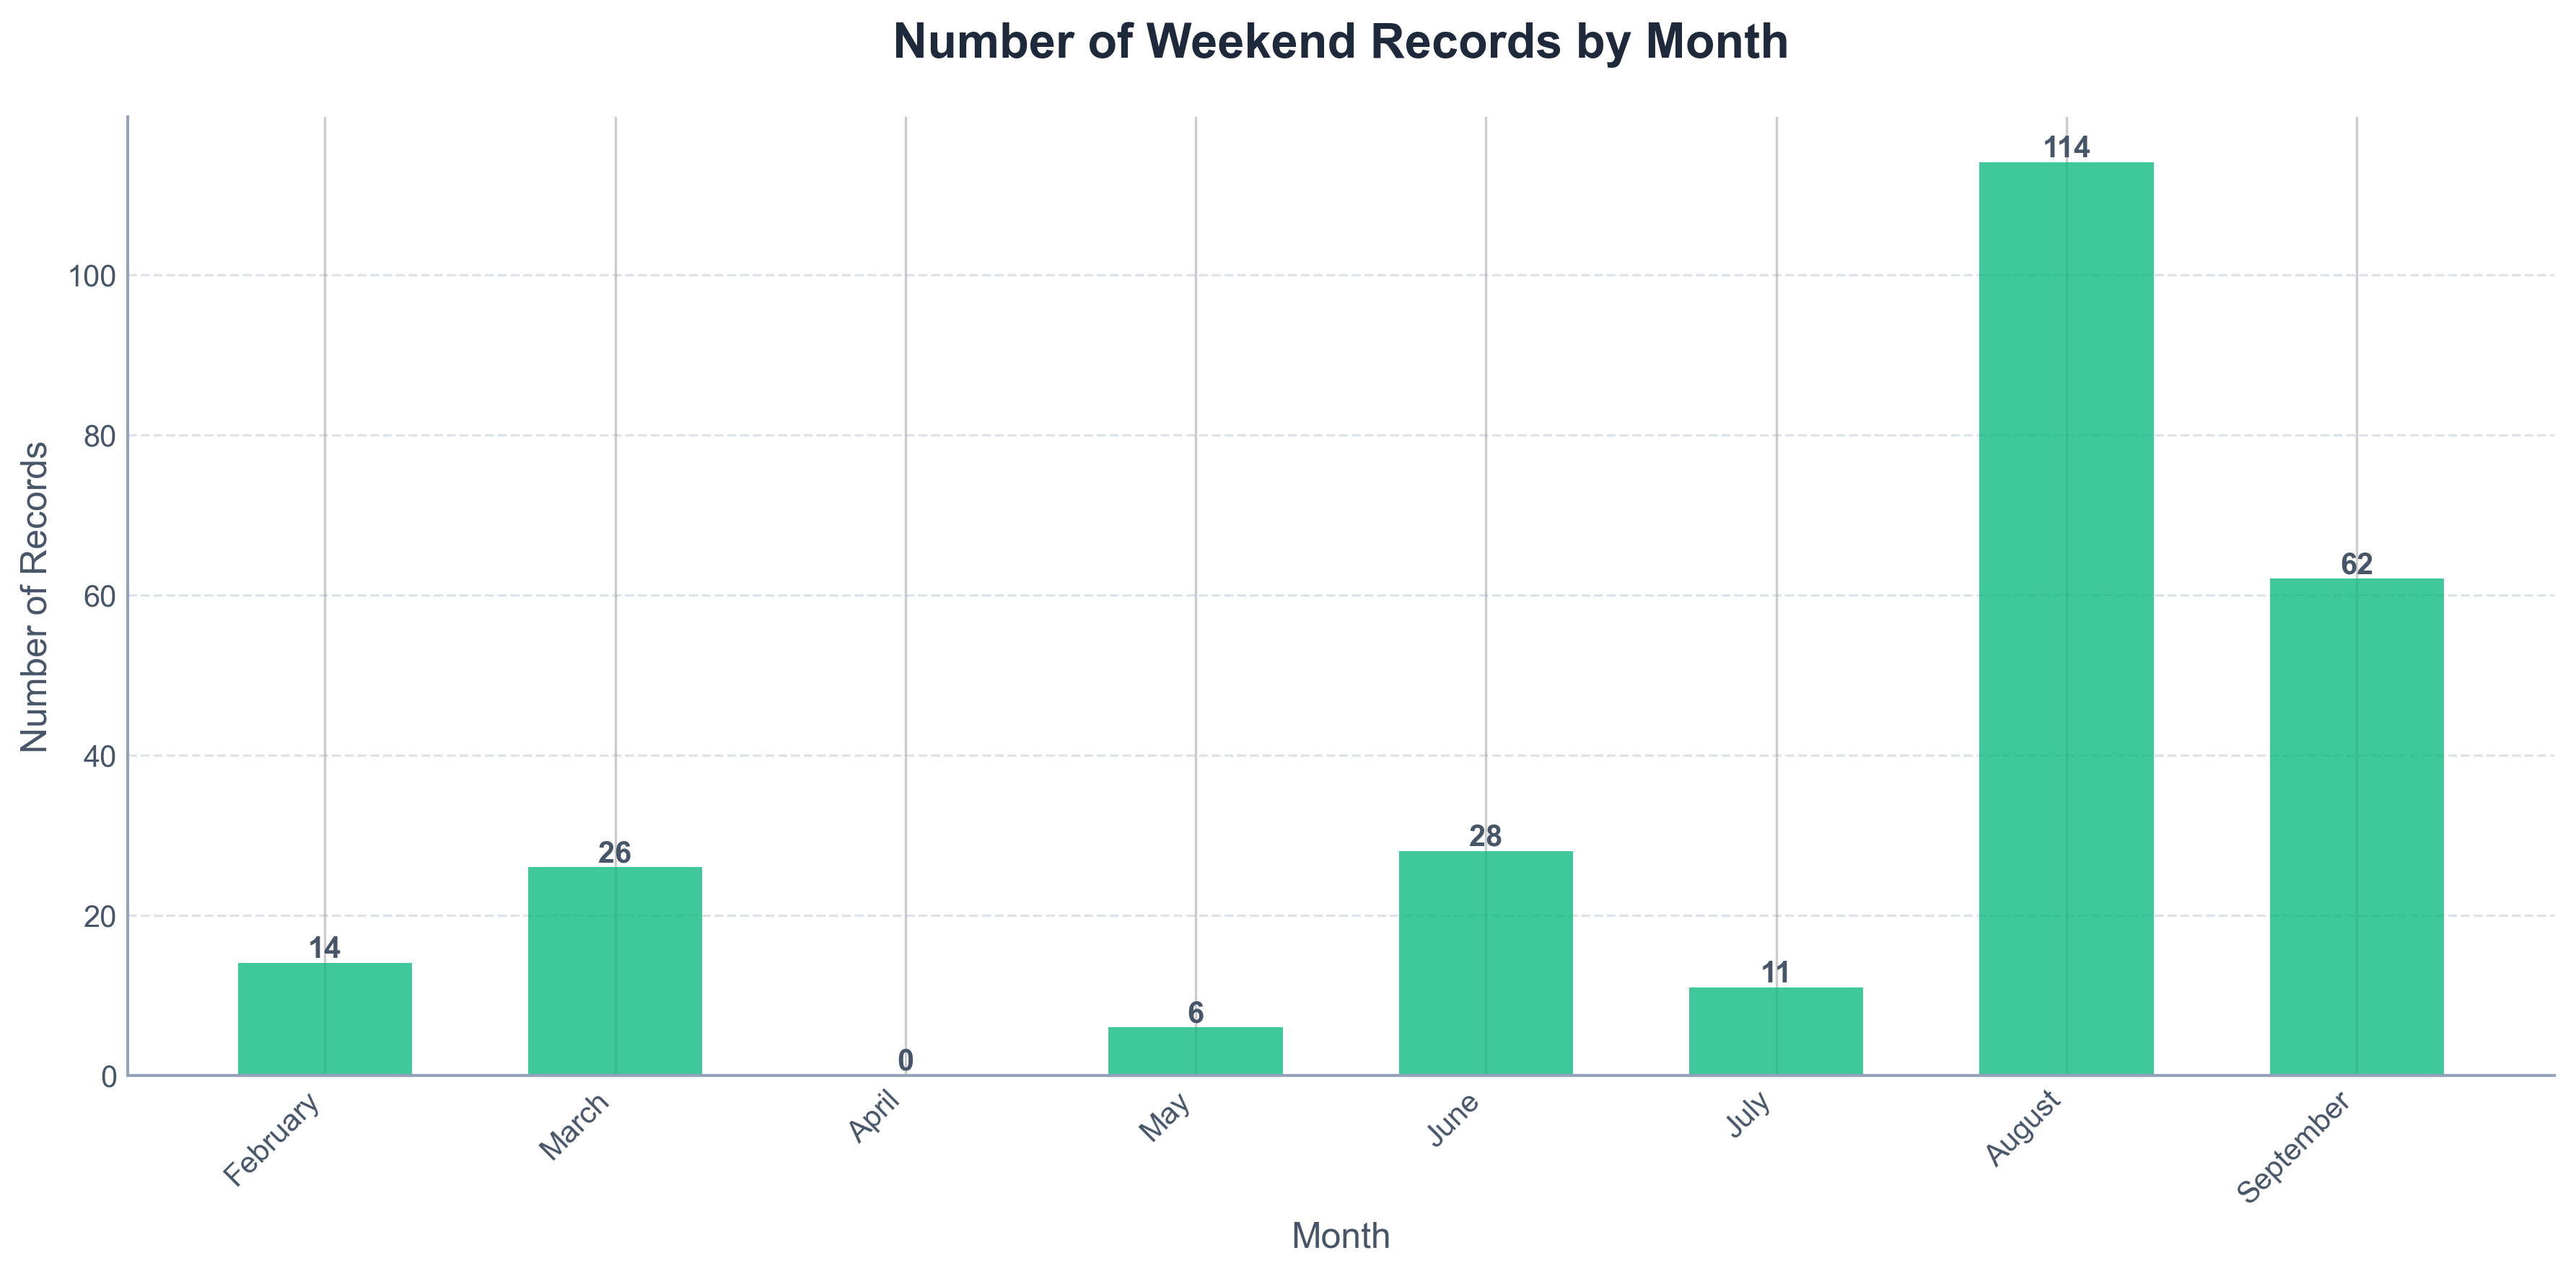

In [26]:
# Call function with merged_df
plot_weekend_records(merged_df)

## Filtering Weekend Data

In [5]:
def filter_weekday_records(df):
    """Filter dataframe to include only weekday records (Mon-Fri)."""
    weekdays = range(5)  # 0-4 represents Monday-Friday
    return df[df['weekday'].isin(weekdays)].copy(deep=True)

filtered_df1 = filter_weekday_records(merged_df)

In [30]:
def plot_weekday_comparison(merged_df, filtered_df):
    """
    Creates a modern, professional comparison plot of records before and after weekend filtering.
    
    Args:
        merged_df (pd.DataFrame): DataFrame containing all records
        filtered_df (pd.DataFrame): DataFrame containing only weekday records
    """
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with higher DPI
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    # Get monthly counts and ensure consistent order
    months = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
    all_records = merged_df.groupby(merged_df['time'].dt.strftime('%B')).size().reindex(months, fill_value=0)
    weekday_records = filtered_df.groupby(filtered_df['time'].dt.strftime('%B')).size().reindex(months, fill_value=0)

    # Set up bar positions
    width = 0.35
    x = np.arange(len(months))

    # Custom colors with transparency
    color1 = '#3b82f6'  # Modern blue
    color2 = '#10b981'  # Modern green

    # Create bars with enhanced styling
    bars1 = ax.bar(x - width/2, all_records.values, width, 
                  label='All Records', color=color1, alpha=0.8)
    bars2 = ax.bar(x + width/2, weekday_records.values, width, 
                  label='Weekday Records', color=color2, alpha=0.8)

    # Customize plot
    ax.set_title('Monthly Records: All Days vs Weekdays Only', 
                fontsize=16, pad=20, fontweight='bold', color='#1e293b')
    ax.set_xlabel('Month', fontsize=12, color='#475569', labelpad=10)
    ax.set_ylabel('Number of Records', fontsize=12, color='#475569', labelpad=10)

    # Customize axis
    ax.set_xticks(x)
    ax.set_xticklabels(months, rotation=45, ha='right')

    # Enhanced legend
    ax.legend(loc='upper right', frameon=True, 
             fancybox=True, framealpha=0.95, 
             edgecolor='#e2e8f0', fontsize=10)

    # Add value labels with improved styling
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}',  # Add thousand separator
                   ha='center', va='bottom',
                   fontsize=9, fontweight='bold',
                   color='#475569')

    autolabel(bars1)
    autolabel(bars2)

    # Customize grid
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='#94a3b8')
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#94a3b8')
    ax.spines['bottom'].set_color('#94a3b8')

    # Customize ticks
    ax.tick_params(axis='both', colors='#475569')

    # Add subtle background color
    fig.patch.set_facecolor('#ffffff')
    ax.set_facecolor('#f8fafc')

    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

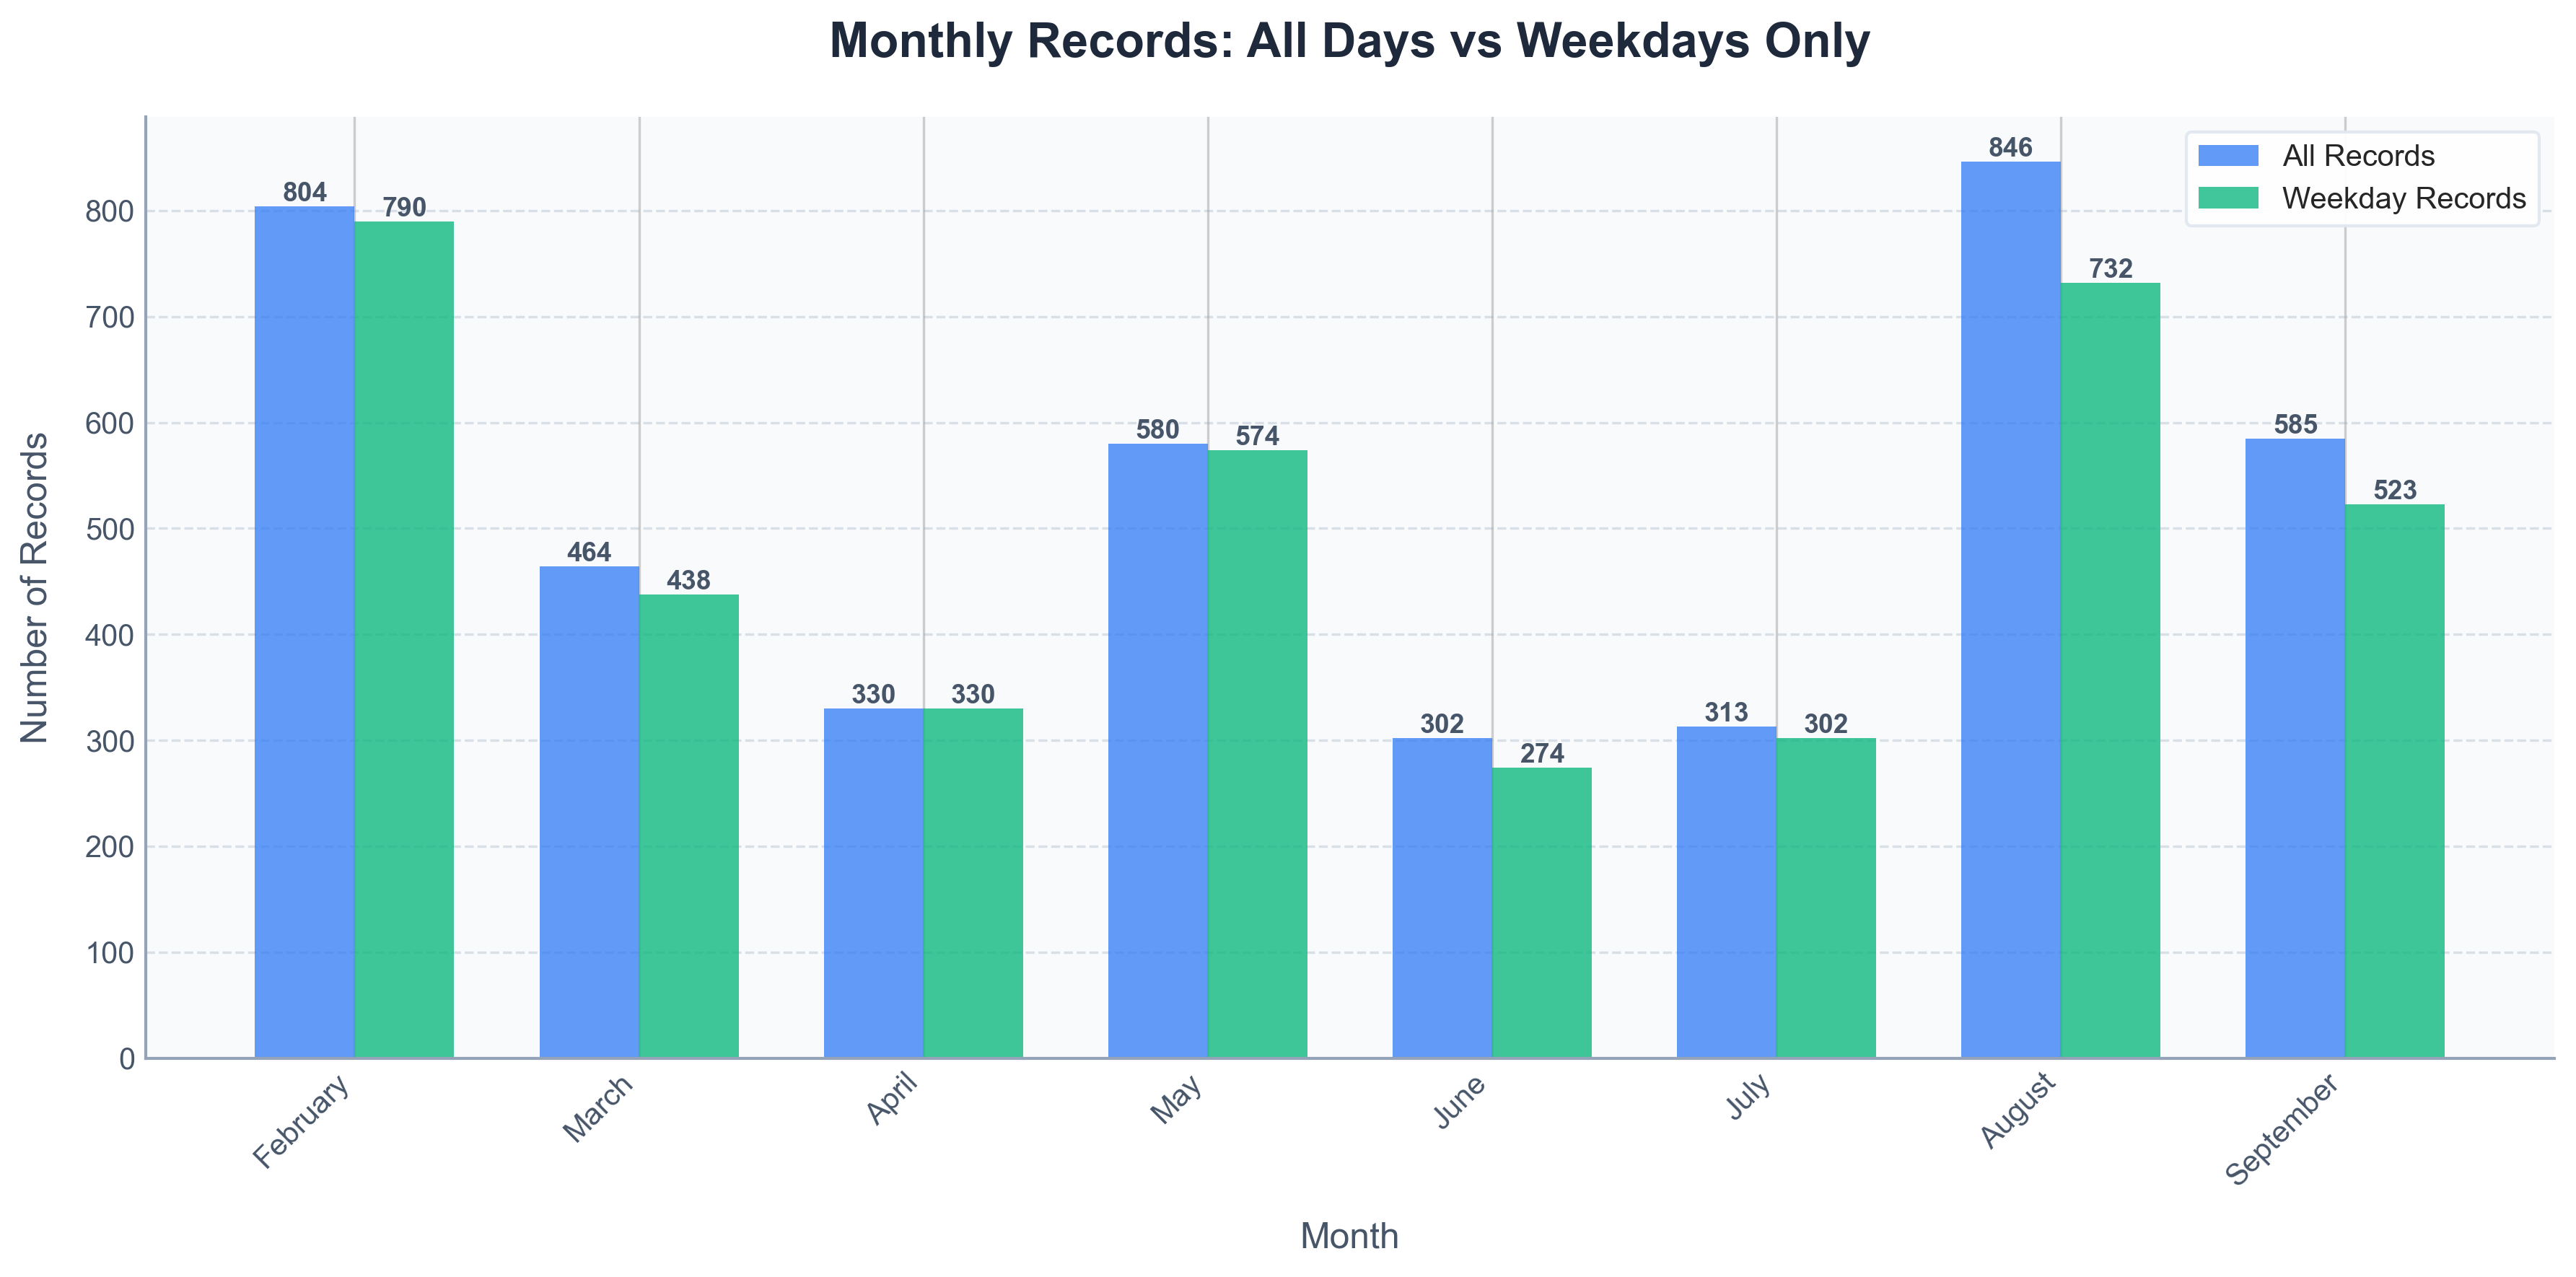

In [31]:
# Call the function with the dataframes
plot_weekday_comparison(merged_df, filtered_df1)

## Filtering out public holiday

In [11]:
def filter_out_holidays(df, holiday_dates):
    """
    Filter out records that fall on holiday dates
    
    Args:
        df: DataFrame containing a 'time' column
        holiday_dates: List of holiday datetime objects
        
    Returns:
        DataFrame with holiday records removed
    """
    return df[~df['time'].dt.date.isin([h.date() for h in holiday_dates])].copy()

filtered_df2 = filter_out_holidays(filtered_df1, holiday_dates)

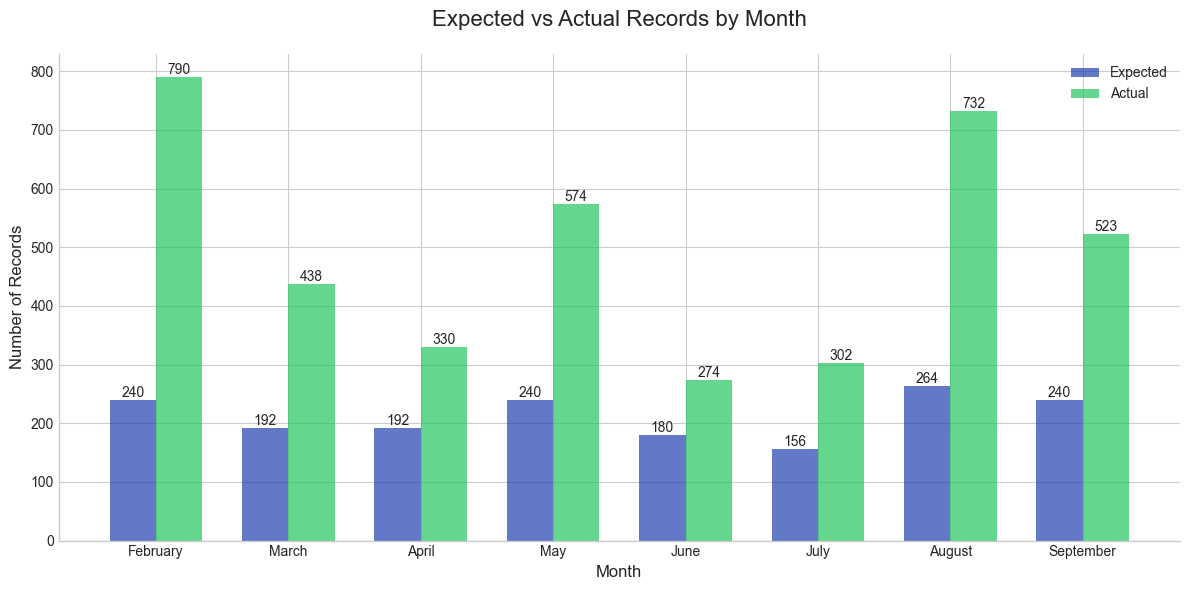

In [33]:
plot_expected_vs_actual_records(monthly_data, filtered_df1)

## Filtering the operational hours for each month

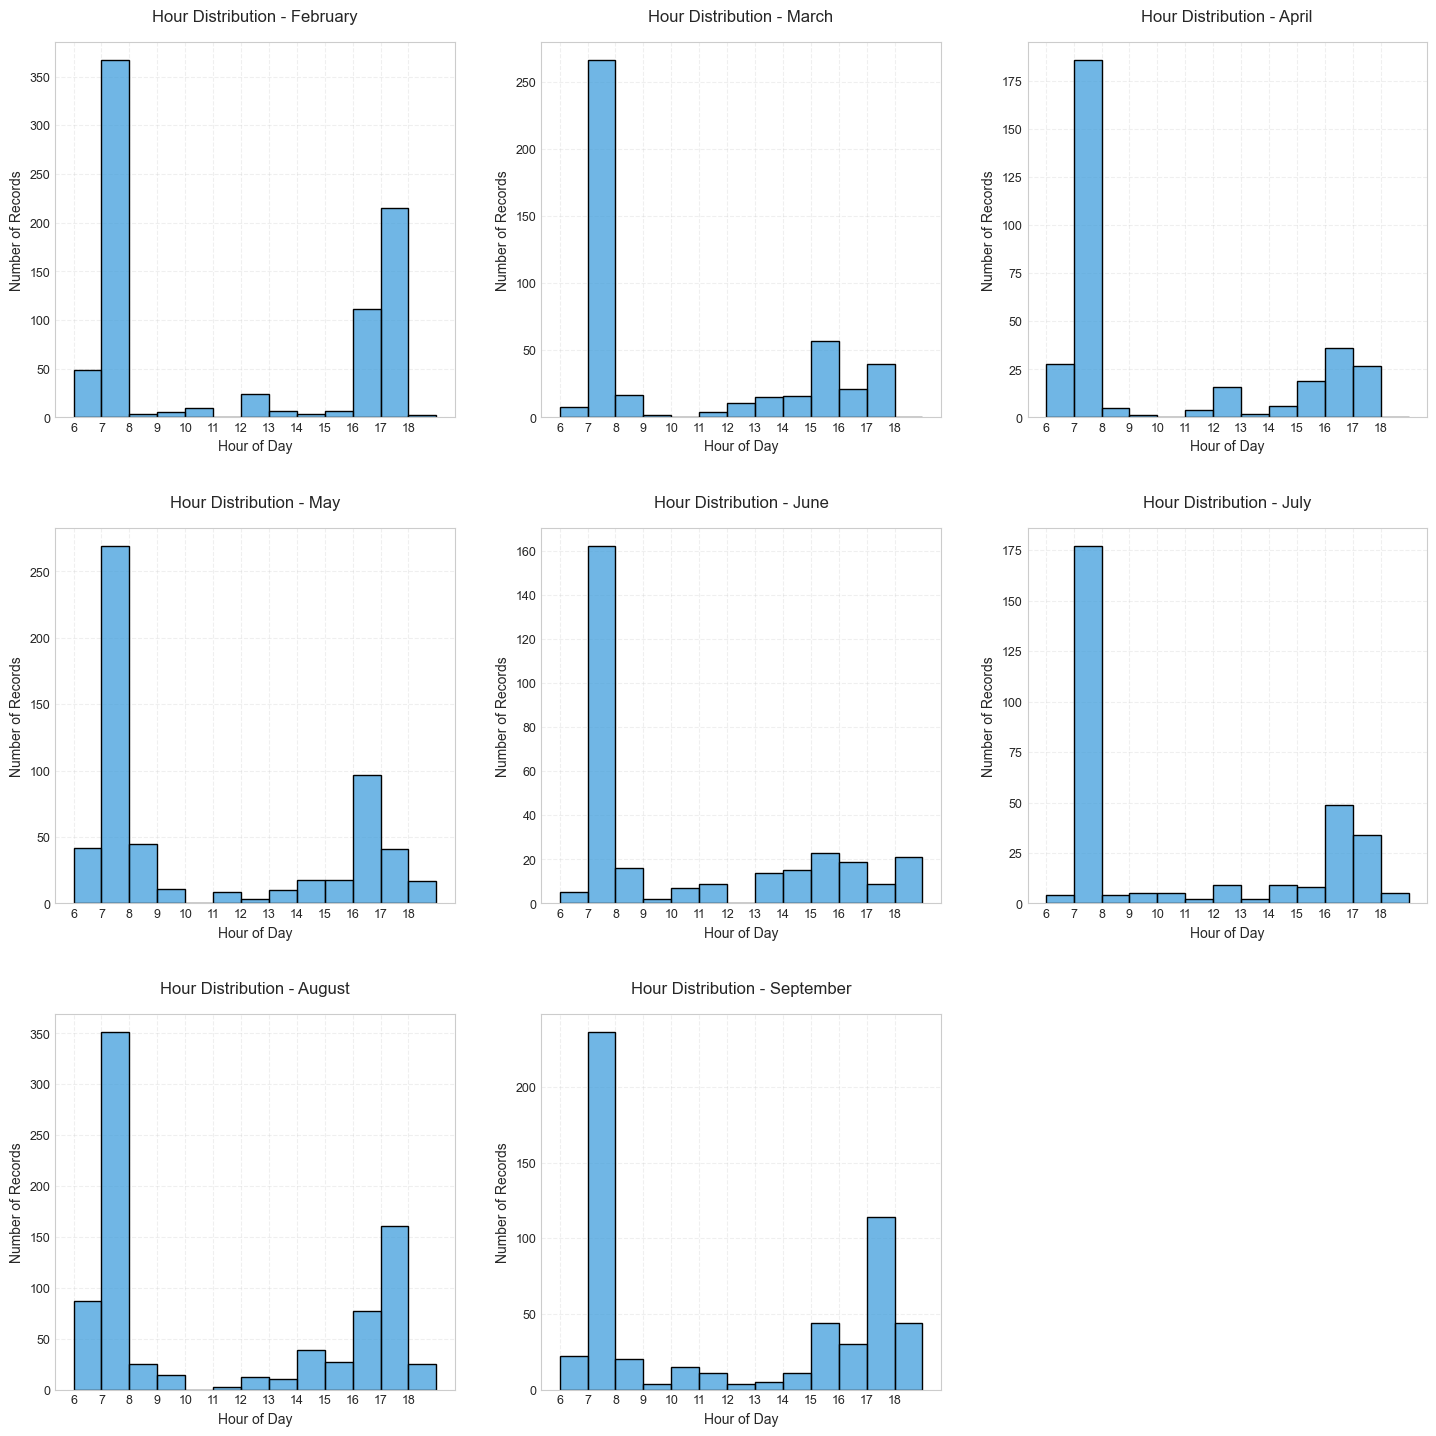

In [12]:
def plot_hour_distribution(df, month_name, ax):
    # Create histogram with custom style
    sns.histplot(
        data=df,
        x='hour',
        bins=range(6, 20),
        kde=False,
        color='#3498db',  # Nice blue color
        alpha=0.7,
        ax=ax
    )
    
    # Customize title and labels with better fonts
    ax.set_title(f'Hour Distribution - {month_name}', fontsize=12, pad=15)
    ax.set_xlabel('Hour of Day', fontsize=10)
    ax.set_ylabel('Number of Records', fontsize=10)
    
    # Customize ticks
    ax.set_xticks(range(6, 19))
    ax.tick_params(axis='both', labelsize=9)
    
    # Add grid with custom style
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add spines
    for spine in ax.spines.values():
        spine.set_color('#cccccc')
        spine.set_linewidth(0.8)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with better spacing
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Dictionary of months and dataframes
month_dfs = {
    'February': feb_df,
    'March': march_df, 
    'April': april_df,
    'May': may_df,
    'June': june_df,
    'July': july_df,
    'August': august_df,
    'September': september_df
}

# Plot each month
for i, (month, df) in enumerate(month_dfs.items()):
    plot_hour_distribution(df, month, axes[i])

# Remove empty subplots
for j in range(len(month_dfs), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

In [13]:
def filter_operational_hours(df, morning_start_time='06:30:00', morning_end_time='08:00:00', 
                           afternoon_start_time='15:00:00', afternoon_end_time='18:00:00'):
    """
    Filter DataFrame to only include records within specified operational hours.
    
    Args:
        df (pd.DataFrame): DataFrame containing a 'time' column
        morning_start_time (str): Start time for morning period (HH:MM:SS)
        morning_end_time (str): End time for morning period (HH:MM:SS) 
        afternoon_start_time (str): Start time for afternoon period (HH:MM:SS)
        afternoon_end_time (str): End time for afternoon period (HH:MM:SS)
    
    Returns:
        pd.DataFrame: Filtered DataFrame
    """
    # Create a copy to avoid modifying original
    df = df.copy()
    
    # Extract the time component
    df['time_component'] = df['time'].dt.time

    # Define the time ranges
    morning_start = pd.to_datetime(morning_start_time).time()
    morning_end = pd.to_datetime(morning_end_time).time()
    afternoon_start = pd.to_datetime(afternoon_start_time).time()
    afternoon_end = pd.to_datetime(afternoon_end_time).time()

    # Filter the DataFrame
    df = df[
        ((df['time_component'] >= morning_start) & (df['time_component'] <= morning_end)) |
        ((df['time_component'] >= afternoon_start) & (df['time_component'] <= afternoon_end))
    ]

    # Clean up
    df.drop(columns=['time_component'], inplace=True)
    
    return df

# Apply the filter
filtered_df3 = filter_operational_hours(filtered_df2)

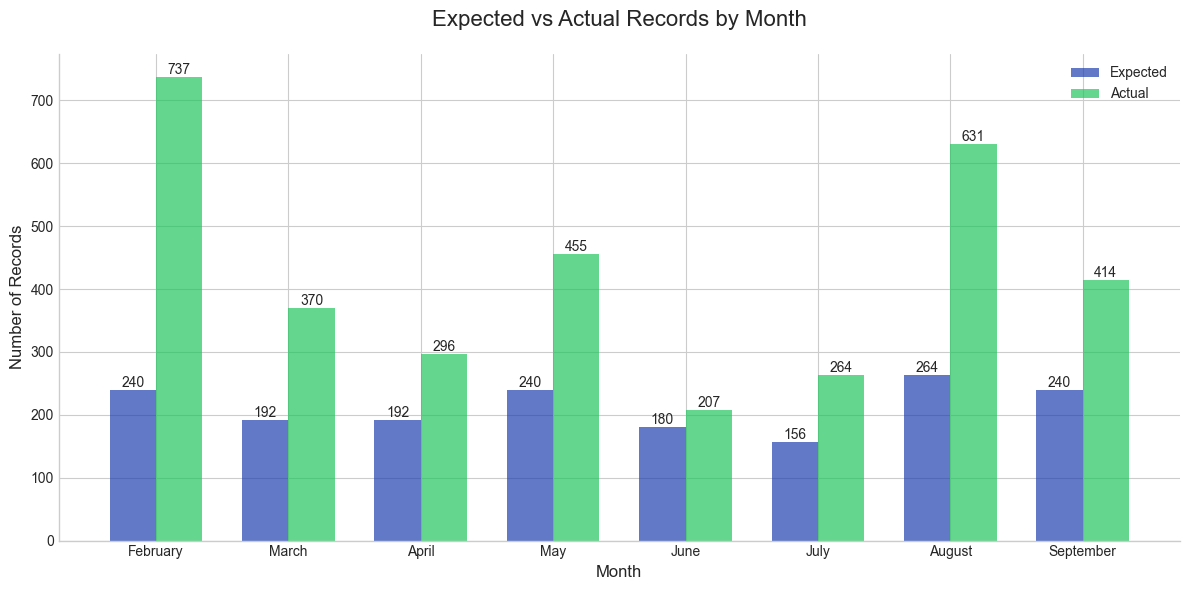

In [36]:
plot_expected_vs_actual_records(monthly_data, filtered_df3)

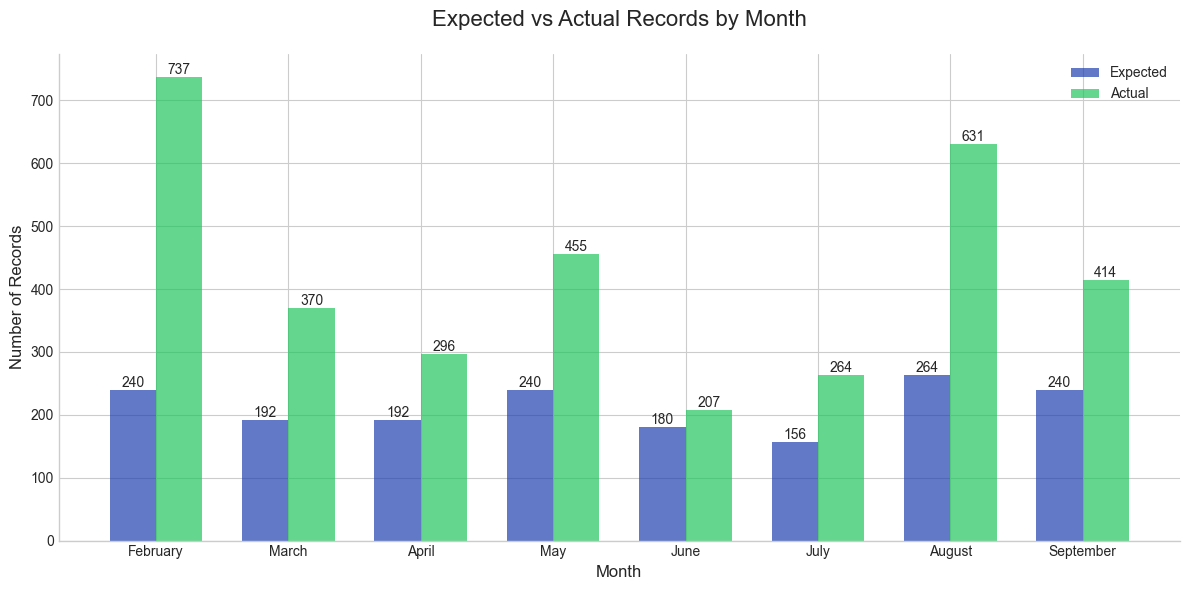

In [37]:
plot_expected_vs_actual_records(monthly_data, filtered_df3)

In [14]:
len(filtered_df3)

3374

## Standardizing Coordinates

In [15]:
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import LineString, Point
from haversine import haversine
from geopy.distance import geodesic

from sklearn.cluster import DBSCAN

### Visualizing Coordinates  for each month

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots with 5 rows and 1 column
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=("February GPS Data", "March GPS Data", "May GPS Data", "August GPS Data", "September GPS Data"),
    vertical_spacing=0.1  # Adjusts the space between the subplots
)

# February Data Plot
fig.add_trace(
    go.Scatter(
        x=feb_df['longitude'], y=feb_df['latitude'],
        mode='markers',
        marker=dict(color='green', size=6),
        name='Feb GPS Data'),
    row=1, col=1
)

# March Data Plot
fig.add_trace(
    go.Scatter(
        x=march_df['longitude'], y=march_df['latitude'],
        mode='markers',
        marker=dict(color='red', size=6),
        name='March GPS Data'),
    row=2, col=1
)

# May Data Plot
fig.add_trace(
    go.Scatter(
        x=may_df['longitude'], y=may_df['latitude'],
        mode='markers',
        marker=dict(color='purple', size=6),
        name='May GPS Data'),
    row=3, col=1
)

# August Data Plot
fig.add_trace(
    go.Scatter(
        x=august_df['longitude'], y=august_df['latitude'],
        mode='markers',
        marker=dict(color='orange', size=6),
        name='Aug GPS Data'),
    row=4, col=1
)

# September Data Plot
fig.add_trace(
    go.Scatter(
        x=september_df['longitude'], y=september_df['latitude'],
        mode='markers',
        marker=dict(color='brown', size=6),
        name='Sept GPS Data'),
    row=5, col=1
)

# Bus stop coordinates
bus_stop_coord_decimal_provided = {
    'SPBU Tlogomas': (-7.931114, 112.602828),
    'SD Dinoyo 2': (-7.943500, 112.610656),
    'SMA 9': (-7.937289, 112.625956),
    'SMA 8': (-7.956453, 112.616703),
    'MAN 2': (-7.960214, 112.622072),
    'SMA Dempo': (-7.968139, 112.623925),
    'SMP 1': (-7.972583, 112.622492),
    'SMA 4': (-7.976606, 112.634336)
}

# Add bus stop coordinates to each subplot
for stop, (lat, lon) in bus_stop_coord_decimal_provided.items():
    for row in range(1, 6):  # Now we have 5 rows
        fig.add_trace(
            go.Scatter(
                x=[lon], y=[lat], mode='markers+text', text=[stop], textposition="top center",
                marker=dict(color='black', size=8), textfont=dict(color='black'),
                showlegend=False),
            row=row, col=1
        )

# Update layout
fig.update_layout(
    title_text="Comparison of Bus Stop Locations vs GPS Data Across Five Months",
    height=1800, width=1400,  # Adjusted height for 5 subplots
    showlegend=False
)

# Show the figure
fig.show()

In [44]:
import folium
from folium import plugins

def plot_bus_stops_map(df, bus_stops_dict=None, center=[-7.95, 112.62]):
    """
    Creates an interactive map showing bus stops and GPS data points.
    
    Args:
        df: DataFrame containing latitude and longitude columns
        bus_stops_dict: Dictionary of bus stop names and their coordinates
        center: Center coordinates for the map [lat, lon]
    """
    # Create base map
    m = folium.Map(
        location=center,
        zoom_start=13,
        tiles='cartodbpositron'  # Modern, clean map style
    )
    
    # Create a marker cluster for GPS points
    marker_cluster = plugins.MarkerCluster(
        name='GPS Points',
        overlay=True,
        control=True,
        icon_create_function=None
    )

    # Add GPS points to cluster
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color='#3b82f6',
            fill=True,
            popup=f"Time: {row['time']}<br>Route: {row['route_id']}",
            opacity=0.7
        ).add_to(marker_cluster)

    # Add bus stops if provided
    if bus_stops_dict:
        bus_stops = folium.FeatureGroup(name='Bus Stops')
        for stop_name, coords in bus_stops_dict.items():
            folium.Marker(
                location=coords,
                popup=stop_name,
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(bus_stops)
        bus_stops.add_to(m)

    # Add the marker cluster to the map
    marker_cluster.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)

    return m

# Bus stop coordinates (from your data)
bus_stop_coordinates = {
    'SPBU Tlogomas': (-7.931114, 112.602828),
    'SD Dinoyo 2': (-7.943500, 112.610656),
    'SMA 9': (-7.937289, 112.625956),
    'SMA 8': (-7.956453, 112.616703),
    'MAN 2': (-7.960214, 112.622072),
    'SMA Dempo': (-7.968139, 112.623925),
    'SMP 1': (-7.972583, 112.622492),
    'SMA 4': (-7.976606, 112.634336)
}

# Create map for all data points
all_points_map = plot_bus_stops_map(
    filtered_df3, 
    bus_stops_dict=bus_stop_coordinates
)

# Display the map
all_points_map

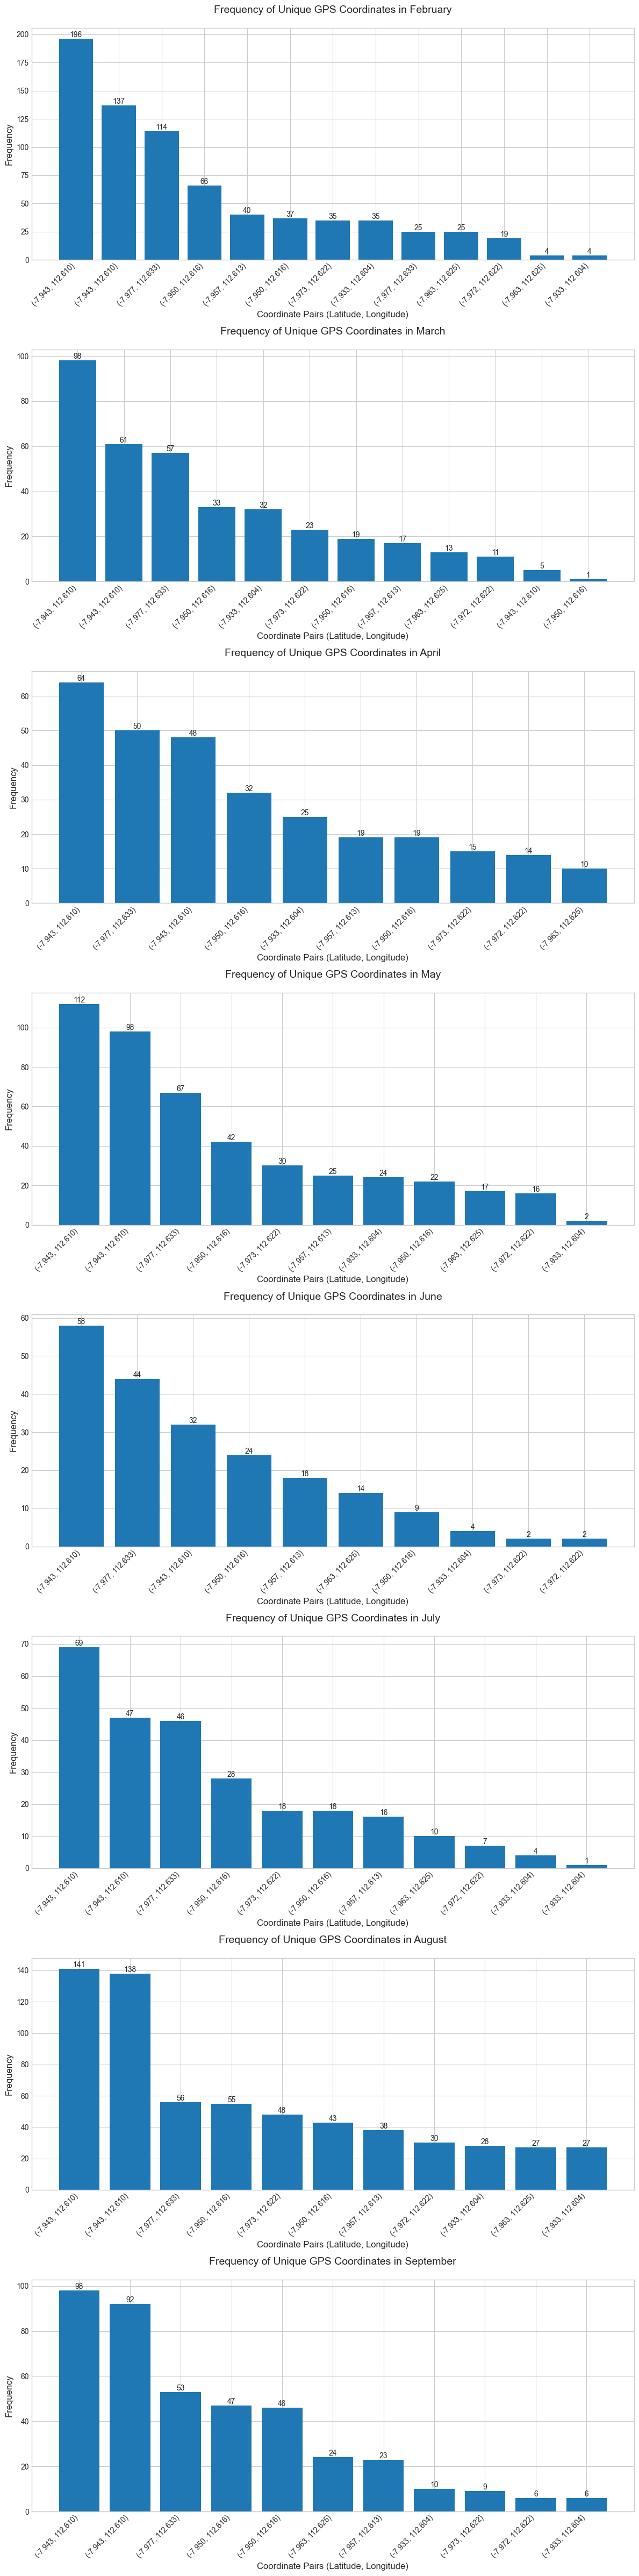

In [45]:
# Get list of unique months
months = filtered_df3['month_name'].unique()

# Create subplots for each month
fig, axes = plt.subplots(len(months), 1, figsize=(12, 6*len(months)))

for i, month in enumerate(months):
    # Filter data for current month
    month_df = filtered_df3[filtered_df3['month_name'] == month]
    
    # Create frequency table of lat/long combinations
    location_freq = month_df.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
    
    # Sort by frequency in descending order
    location_freq = location_freq.sort_values('frequency', ascending=False)
    
    # Create bar chart
    bars = axes[i].bar(range(len(location_freq)), location_freq['frequency'])
    
    # Customize chart
    axes[i].set_title(f'Frequency of Unique GPS Coordinates in {month}', fontsize=14, pad=20)
    axes[i].set_xlabel('Coordinate Pairs (Latitude, Longitude)', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    
    # Add coordinate labels
    axes[i].set_xticks(range(len(location_freq)))
    axes[i].set_xticklabels([f'({lat:.3f}, {lon:.3f})' for lat, lon in zip(location_freq['latitude'], location_freq['longitude'])],
                           rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
def perform_clustering(df):
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)],
        crs="EPSG:4326"
    )

    # Apply DBSCAN clustering
    db = DBSCAN(eps=0.001, min_samples=5).fit(np.array(gdf.geometry.apply(lambda p: (p.x, p.y)).tolist()))
    gdf['cluster_id'] = db.labels_

    return gdf  # Return only the GeoDataFrame with added cluster labels


def renumber_clusters_based_on_stop_id(gdf):
    # Ensure 'Stop_Id' is sorted in the order you want (e.g., 'BT01', 'BT02', ..., 'BT08')
    ordered_stops = ['BT01', 'BT02', 'BT03', 'BT04', 'BT05', 'BT06', 'BT07', 'BT08']

    # Create a mapping from Stop_Id to a sequential number starting from 1
    stop_id_to_sequential = {stop: i + 1 for i, stop in enumerate(ordered_stops)}

    # Apply this mapping to the Stop_Id to create a new sequential cluster_id
    gdf['sequential_cluster_id'] = gdf['Stop_Id'].map(stop_id_to_sequential)

    return gdf

In [17]:
filtered_gdf3 = perform_clustering(filtered_df3)

In [18]:
def plot_clusters(gdf, month_name):
    # Set up the plot
    plt.figure(figsize=(10, 6))
    # Generate a discrete colormap
    num_clusters = gdf['cluster_id'].nunique()
    cmap = plt.cm.get_cmap('Set1', num_clusters)  # Get a colormap with `num_clusters` discrete colors

    # Scatter plot for clusters
    scatter = plt.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf['cluster_id'], cmap=cmap, edgecolor='k', s=50)

    # Create colorbar with discrete boundaries
    cbar = plt.colorbar(scatter, ticks=np.arange(num_clusters)+0.5, spacing='proportional')
    cbar.set_ticklabels(np.arange(1, num_clusters+1))
    cbar.set_label('Cluster ID')

    # Annotate each point with its cluster ID
    for i, point in gdf.iterrows():
        plt.annotate(text=str(point['cluster_id']), xy=(point.geometry.x, point.geometry.y),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

    plt.title(f'Visualizing Bus Stops as Clusters for {month_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)  # Optional: turn on grid for better alignment
    plt.show()

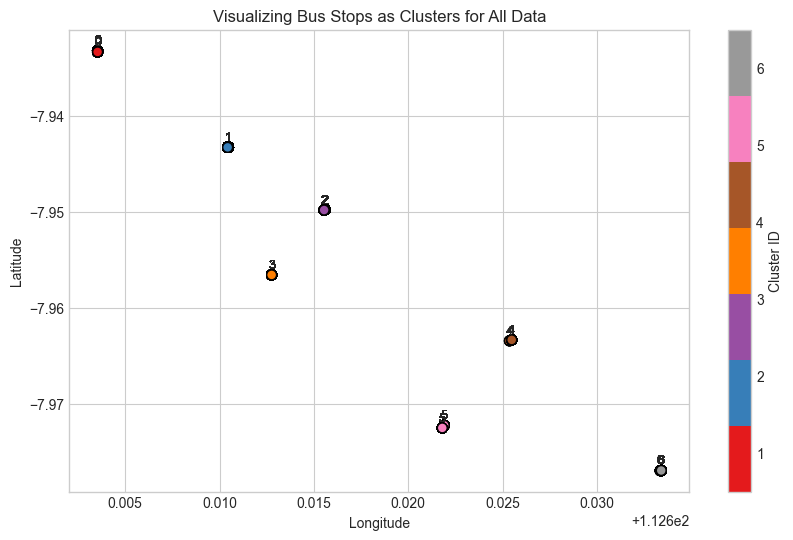

In [19]:
plot_clusters(filtered_gdf3, "All Data")

In [20]:
def standardize_bus_stop_locations(gdf):
    """
    Standardizes bus stop locations by calculating the modal coordinates for each cluster
    represented by 'cluster_id'. These modal coordinates represent the most
    common GPS coordinates for each bus stop, presumed to be the actual location of the stops.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing the bus stop data with clusters.

    Returns:
    GeoDataFrame: The updated GeoDataFrame with standardized bus stop coordinates.
    """

    # Function to calculate the modal point for each group of points
    def calculate_modal_point(geometry):
        x_coords = [point.x for point in geometry]
        y_coords = [point.y for point in geometry]
        x_mode = pd.Series(x_coords).mode()[0]  # Most frequent x coordinate
        y_mode = pd.Series(y_coords).mode()[0]  # Most frequent y coordinate
        return Point(x_mode, y_mode)

    # Grouping the data by 'cluster_id' and calculating modal point for each group
    bus_stop_centroids = gdf.groupby('cluster_id').agg({
        'geometry': calculate_modal_point  # Applying the modal point function to the 'geometry' column
    }).reset_index().rename(columns={'geometry': 'geometry_standard'})

    # Merging the modal points back into the original GeoDataFrame
    gdf = gdf.merge(bus_stop_centroids, on='cluster_id', suffixes=('', '_standard'))

    # Replace latitude and longitude columns with the standardized geometry
    gdf['latitude'] = gdf['geometry_standard'].apply(lambda point: point.y)
    gdf['longitude'] = gdf['geometry_standard'].apply(lambda point: point.x)

    return gdf

def add_stop_info(df):
    """
    Adds Stop_Name and Stop_ID columns to the DataFrame based on cluster_id.

    Parameters:
    - df: DataFrame containing the cluster_id column.
    - stop_info: Dictionary mapping cluster_id to Stop_Name and Stop_ID.
    """

    # Stop information for each month
    cluster_stop_map = {
        0: ('SPBU Tlogomas', 'BT01'),
        1: ('SD Dinoyo 2', 'BT02'),
        2: ('SMA 8', 'BT03'),
        3: ('SMA 8', 'BT04'),
        4: ('MAN 2', 'BT05'),
        5: ('SMA Dempo', 'BT06'),
        6: ('SMP 4', 'BT07')
    }

    df['Stop_Name'] = df['cluster_id'].map(lambda x: cluster_stop_map[x][0])
    df['Stop_ID'] = df['cluster_id'].map(lambda x: cluster_stop_map[x][1])
    return df


def remove_clustering_columns(gdf):
    gdf = gdf.drop(columns=['cluster_id', 'geometry'])
    return gdf

def remove_noise(df, cluster_col='cluster_id'):
    """
    Removes rows labeled as noise in the specified cluster column.

    Parameters:
    - df: DataFrame containing the cluster column.
    - cluster_col: The column name for the cluster labels (default is 'cluster_id').

    Returns:
    - DataFrame with noise rows removed.
    """
    return df[df[cluster_col] != -1]

standardized_filtered_df = standardize_bus_stop_locations(filtered_gdf3)
standardized_filtered_df = add_stop_info(standardized_filtered_df)
standardized_filtered_df = remove_noise(standardized_filtered_df)
standardized_filtered_df = remove_clustering_columns(standardized_filtered_df)

In [23]:
unique_stops_df = standardized_filtered_df[['Stop_ID', 'latitude', 'longitude']].drop_duplicates()

In [24]:
unique_stops_df.set_index('Stop_ID')

latitude  longitude
Stop_ID                     
BT01     -7.93324  112.60354
BT02     -7.94329  112.61047
BT03     -7.94979  112.61559
BT04     -7.95658  112.61276
BT05     -7.96334  112.62548
BT06     -7.97250  112.62180
BT07     -7.97693  112.63340

## removing duplicates

In [25]:
from datetime import timedelta

def mark_and_remove_consecutive_duplicates(df, column_list, time_col='time', minutes=5):
    """
    Marks consecutive duplicates within a specified time window and removes them,
    keeping the first entry of each duplicate set.
    """
    # Ensure the DataFrame is sorted for proper sequential comparison
    df.sort_values(by=[time_col] + column_list, inplace=True)

    # Initialize a column to mark duplicates
    df['is_duplicate'] = False

    # Use shift to compare each row with the previous one
    previous_rows = df.shift(1)
    time_diff = (df[time_col] - previous_rows[time_col]).abs() <= timedelta(minutes=minutes)

    # Check for duplication in specified columns and within the time window
    for column in column_list:
        df['is_duplicate'] |= (df[column] == previous_rows[column]) & time_diff

    # Keep only the first record of duplicates by marking subsequent ones
    # First record will not be marked since there's no previous duplicate within the window
    cleaned_df = df[~df['is_duplicate']].drop(columns=['is_duplicate'])
    return cleaned_df

column_list = ['geometry_standard']  # Columns to consider for duplicate checking

standardized_filtered_deduped_df = mark_and_remove_consecutive_duplicates(standardized_filtered_df, column_list)

# Optionally, print the size of the original and cleaned datasets to see how many entries were removed
print(f"Original: {len(standardized_filtered_df)}, Cleaned: {len(standardized_filtered_deduped_df)}")

Original: 3374, Cleaned: 1546


In [27]:
standardized_filtered_deduped_df

route_id  latitude  longitude                time  hour  weekday  \
0           10  -7.93324  112.60354 2024-02-01 06:54:08     6        3   
2           10  -7.94329  112.61047 2024-02-01 07:00:07     7        3   
3           10  -7.94979  112.61559 2024-02-01 07:09:44     7        3   
5           10  -7.94329  112.61047 2024-02-01 07:11:05     7        3   
12          10  -7.95658  112.61276 2024-02-01 07:15:01     7        3   
...        ...       ...        ...                 ...   ...      ...   
3206        10  -7.97693  112.63340 2024-09-30 07:30:02     7        0   
3209        10  -7.93324  112.60354 2024-09-30 07:36:45     7        0   
3210        10  -7.94329  112.61047 2024-09-30 07:41:36     7        0   
3370        11  -7.97250  112.62180 2024-09-30 16:42:26    16        0   
3372        11  -7.94979  112.61559 2024-09-30 17:11:34    17        0   

      day_name  month month_name           geometry_standard      Stop_Name  \
0     Thursday      2   February  POINT (112.60354 -7.93324)  SPBU Tlogomas   
2     Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
3     Thursday      2   February  POINT (112.61559 -7.94979)          SMA 8   
5     Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
12    Thursday      2   February  POINT (112.61276 -7.95658)          SMA 8   
...        ...    ...        ...                         ...            ...   
3206    Monday      9  September   POINT (112.6334 -7.97693)          SMP 4   
3209    Monday      9  September  POINT (112.60354 -7.93324)  SPBU Tlogomas   
3210    Monday      9  September  POINT (112.61047 -7.94329)    SD Dinoyo 2   
3370    Monday      9  September    POINT (112.6218 -7.9725)      SMA Dempo   
3372    Monday      9  September  POINT (112.61559 -7.94979)          SMA 8   

     Stop_ID  
0       BT01  
2       BT02  
3       BT03  
5       BT02  
12      BT04  
...      ...  
3206    BT07  
3209    BT01  
3210    BT02  
3370    BT06  
3372    BT03  

[1546 rows x 12 columns]

In [28]:
def remove_duplicates_standardized(df, geom_col='geometry_standard', time_col='time', time_threshold=timedelta(minutes=5)):
    """
    Removes duplicates from standardized GPS data based on the standardized location and time proximity.
    
    :param df: DataFrame with standardized GPS data
    :param geom_col: Name of the column containing standardized Point objects
    :param time_col: Name of the column containing timestamps
    :param time_threshold: Time threshold for considering points as duplicates
    :return: DataFrame with duplicates removed
    """
    print(f"Initial shape: {df.shape}")
    
    # Sort the dataframe by time
    df_sorted = df.sort_values(by=time_col)
    
    # Initialize list to keep track of rows to keep
    rows_to_keep = []
    
    # Iterate through sorted dataframe
    for i, row in df_sorted.iterrows():
        if not rows_to_keep:
            # Always keep the first row
            rows_to_keep.append(i)
        else:
            # Get the last kept row
            last_kept = df_sorted.loc[rows_to_keep[-1]]
            
            # Check if current row has a different standardized location or is beyond time threshold
            if (row[geom_col] != last_kept[geom_col] or 
                (row[time_col] - last_kept[time_col]) > time_threshold):
                rows_to_keep.append(i)
    
    # Create new dataframe with only the rows to keep
    df_deduplicated = df_sorted.loc[rows_to_keep]
    
    print(f"Shape after removing duplicates: {df_deduplicated.shape}")
    print(f"Number of duplicates removed: {df.shape[0] - df_deduplicated.shape[0]}")
    
    return df_deduplicated

# remove duplicates
deduplicated_df = remove_duplicates_standardized(standardized_filtered_df)

# Display the first few rows of the deduplicated dataframe
print(deduplicated_df.head())

# Additional analysis
time_diffs = deduplicated_df['time'].diff()
print("\nTime difference statistics between consecutive points:")
print(time_diffs.describe())

print("\nNumber of points with time difference <= 5 minutes:")
print((time_diffs <= timedelta(minutes=5)).sum())

# Check for any remaining duplicates
duplicates = deduplicated_df.duplicated(subset=['geometry_standard', 'time'], keep=False)
print(f"\nNumber of remaining duplicates: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("\nExample of remaining duplicates:")
    print(deduplicated_df[duplicates].head())

print(f"Original: {len(standardized_filtered_df)}, Cleaned: {len(deduplicated_df)}")

Initial shape: (3374, 13)
Shape after removing duplicates: (1547, 13)
Number of duplicates removed: 1827
    route_id  latitude  longitude                time  hour  weekday  \
0         10  -7.93324  112.60354 2024-02-01 06:54:08     6        3   
2         10  -7.94329  112.61047 2024-02-01 07:00:07     7        3   
3         10  -7.94979  112.61559 2024-02-01 07:09:44     7        3   
5         10  -7.94329  112.61047 2024-02-01 07:11:05     7        3   
12        10  -7.95658  112.61276 2024-02-01 07:15:01     7        3   

    day_name  month month_name           geometry_standard      Stop_Name  \
0   Thursday      2   February  POINT (112.60354 -7.93324)  SPBU Tlogomas   
2   Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
3   Thursday      2   February  POINT (112.61559 -7.94979)          SMA 8   
5   Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
12  Thursday      2   February  POINT (112.61276 -7.95658)          SMA 8   


## Generating Trips Data

In [29]:
def create_trip_dataframe(gdf, route_col='route_id', time_col='time', geom_col='geometry_standard', stop_id_col='Stop_ID'):
    """
    Extends the GeoDataFrame with additional trip attributes.
    """
    # Sort the data by route and time to ensure correct sequence
    gdf_sorted = gdf.sort_values(by=[route_col, time_col])
    gdf_sorted['trip_id'] = gdf_sorted.groupby([route_col]).cumcount() + 1

    segments = []
    for _, group in gdf_sorted.groupby(route_col):
        last_row = None
        for idx, row in group.iterrows():
            if last_row is not None:
                # Create a LineString from the previous stop to the current stop
                line = LineString([last_row[geom_col], row[geom_col]])
                start_coords = (last_row[geom_col].y, last_row[geom_col].x)
                end_coords = (row[geom_col].y, row[geom_col].x)
                distance = geodesic(start_coords, end_coords).kilometers  # Calculate geographic distance
                duration = (row[time_col] - last_row[time_col]).total_seconds() / 60.0  # Duration in minutes

                segments.append({
                    'route_id': row[route_col],
                    'trip_id': last_row['trip_id'],
                    'start_time': last_row['time'],
                    'end_time': row['time'],
                    'start_hour': last_row['hour'],
                    'end_hour': row['hour'],
                    'start_stop': last_row['Stop_Name'],
                    'end_stop': row['Stop_Name'],
                    'start_stop_id': last_row[stop_id_col],
                    'end_stop_id': row[stop_id_col],
                    'start_lat': last_row[geom_col].y,
                    'start_lon': last_row[geom_col].x,
                    'end_lat': row[geom_col].y,
                    'end_lon': row[geom_col].x,
                    'duration': duration,
                    'distance': distance,
                    'segment': line
                })
            last_row = row

    # Convert the list of segments into a GeoDataFrame
    trips_gdf = gpd.GeoDataFrame(segments, geometry='segment')

    return trips_gdf
all_trips = create_trip_dataframe(deduplicated_df)

In [30]:
all_trips

route_id  trip_id          start_time            end_time  start_hour  \
0           10        1 2024-02-01 06:54:08 2024-02-01 07:00:07           6   
1           10        2 2024-02-01 07:00:07 2024-02-01 07:09:44           7   
2           10        3 2024-02-01 07:09:44 2024-02-01 07:11:05           7   
3           10        4 2024-02-01 07:11:05 2024-02-01 07:15:01           7   
4           10        5 2024-02-01 07:15:01 2024-02-01 07:21:56           7   
...        ...      ...                 ...                 ...         ...   
1540        11      399 2024-09-26 17:15:04 2024-09-26 17:26:11          17   
1541        11      400 2024-09-26 17:26:11 2024-09-27 15:11:45          17   
1542        11      401 2024-09-27 15:11:45 2024-09-27 15:20:15          15   
1543        11      402 2024-09-27 15:20:15 2024-09-30 16:42:26          15   
1544        11      403 2024-09-30 16:42:26 2024-09-30 17:11:34          16   

      end_hour     start_stop       end_stop start_stop_id end_stop_id  \
0            7  SPBU Tlogomas    SD Dinoyo 2          BT01        BT02   
1            7    SD Dinoyo 2          SMA 8          BT02        BT03   
2            7          SMA 8    SD Dinoyo 2          BT03        BT02   
3            7    SD Dinoyo 2          SMA 8          BT02        BT04   
4            7          SMA 8          MAN 2          BT04        BT05   
...        ...            ...            ...           ...         ...   
1540        17  SPBU Tlogomas  SPBU Tlogomas          BT01        BT01   
1541        15  SPBU Tlogomas          SMA 8          BT01        BT03   
1542        15          SMA 8    SD Dinoyo 2          BT03        BT02   
1543        16    SD Dinoyo 2      SMA Dempo          BT02        BT06   
1544        17      SMA Dempo          SMA 8          BT06        BT03   

      start_lat  start_lon  end_lat    end_lon     duration  distance  \
0      -7.93324  112.60354 -7.94329  112.61047     5.983333  1.348795   
1      -7.94329  112.61047 -7.94979  112.61559     9.616667  0.914033   
2      -7.94979  112.61559 -7.94329  112.61047     1.350000  0.914033   
3      -7.94329  112.61047 -7.95658  112.61276     3.933333  1.491343   
4      -7.95658  112.61276 -7.96334  112.62548     6.916667  1.589263   
...         ...        ...      ...        ...          ...       ...   
1540   -7.93324  112.60354 -7.93324  112.60354    11.116667  0.000000   
1541   -7.93324  112.60354 -7.94979  112.61559  1305.566667  2.261732   
1542   -7.94979  112.61559 -7.94329  112.61047     8.500000  0.914033   
1543   -7.94329  112.61047 -7.97250  112.62180  4402.183333  3.463606   
1544   -7.97250  112.62180 -7.94979  112.61559    29.133333  2.603276   

                                                segment  
0     LINESTRING (112.60354 -7.93324, 112.61047 -7.9...  
1     LINESTRING (112.61047 -7.94329, 112.61559 -7.9...  
2     LINESTRING (112.61559 -7.94979, 112.61047 -7.9...  
3     LINESTRING (112.61047 -7.94329, 112.61276 -7.9...  
4     LINESTRING (112.61276 -7.95658, 112.62548 -7.9...  
...                                                 ...  
1540  LINESTRING (112.60354 -7.93324, 112.60354 -7.9...  
1541  LINESTRING (112.60354 -7.93324, 112.61559 -7.9...  
1542  LINESTRING (112.61559 -7.94979, 112.61047 -7.9...  
1543  LINESTRING (112.61047 -7.94329, 112.6218 -7.9725)  
1544  LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)  

[1545 rows x 17 columns]

## Removing Long Duration Trips

In [32]:
def remove_long_duration_trips(gdf, max_duration=30, duration_col='duration'):
    """
    Removes trips with durations exceeding a specified maximum from a GeoDataFrame.

    Parameters:
    gdf : GeoDataFrame
        The GeoDataFrame that includes a duration column representing trip durations.
    max_duration : int
        The maximum duration threshold in minutes beyond which records are removed.
    duration_col : str
        The name of the column in gdf that contains the duration data.

    Returns:
    GeoDataFrame
        A GeoDataFrame after removing trips with excessive duration.
    """
    # Filter out trips with duration greater than the specified maximum
    filtered_gdf = gdf[gdf[duration_col] <= max_duration]
    return filtered_gdf

# Applying the function to your monthly data
all_trips_filtered = remove_long_duration_trips(all_trips)


# Optionally, print the size of the original and filtered datasets to see how many entries were removed
print(f"Original: {len(all_trips)}, Filtered: {len(all_trips_filtered)}")

Original: 1545, Filtered: 1278


In [33]:
all_trips_filtered = all_trips_filtered[(all_trips_filtered['distance'] > 0.0)]

In [34]:
all_trips_filtered

route_id  trip_id          start_time            end_time  start_hour  \
0           10        1 2024-02-01 06:54:08 2024-02-01 07:00:07           6   
1           10        2 2024-02-01 07:00:07 2024-02-01 07:09:44           7   
2           10        3 2024-02-01 07:09:44 2024-02-01 07:11:05           7   
3           10        4 2024-02-01 07:11:05 2024-02-01 07:15:01           7   
4           10        5 2024-02-01 07:15:01 2024-02-01 07:21:56           7   
...        ...      ...                 ...                 ...         ...   
1537        11      396 2024-09-26 16:43:11 2024-09-26 17:04:53          16   
1538        11      397 2024-09-26 17:04:53 2024-09-26 17:10:20          17   
1539        11      398 2024-09-26 17:10:20 2024-09-26 17:15:04          17   
1542        11      401 2024-09-27 15:11:45 2024-09-27 15:20:15          15   
1544        11      403 2024-09-30 16:42:26 2024-09-30 17:11:34          16   

      end_hour     start_stop       end_stop start_stop_id end_stop_id  \
0            7  SPBU Tlogomas    SD Dinoyo 2          BT01        BT02   
1            7    SD Dinoyo 2          SMA 8          BT02        BT03   
2            7          SMA 8    SD Dinoyo 2          BT03        BT02   
3            7    SD Dinoyo 2          SMA 8          BT02        BT04   
4            7          SMA 8          MAN 2          BT04        BT05   
...        ...            ...            ...           ...         ...   
1537        17      SMA Dempo          SMA 8          BT06        BT03   
1538        17          SMA 8    SD Dinoyo 2          BT03        BT02   
1539        17    SD Dinoyo 2  SPBU Tlogomas          BT02        BT01   
1542        15          SMA 8    SD Dinoyo 2          BT03        BT02   
1544        17      SMA Dempo          SMA 8          BT06        BT03   

      start_lat  start_lon  end_lat    end_lon   duration  distance  \
0      -7.93324  112.60354 -7.94329  112.61047   5.983333  1.348795   
1      -7.94329  112.61047 -7.94979  112.61559   9.616667  0.914033   
2      -7.94979  112.61559 -7.94329  112.61047   1.350000  0.914033   
3      -7.94329  112.61047 -7.95658  112.61276   3.933333  1.491343   
4      -7.95658  112.61276 -7.96334  112.62548   6.916667  1.589263   
...         ...        ...      ...        ...        ...       ...   
1537   -7.97250  112.62180 -7.94979  112.61559  21.700000  2.603276   
1538   -7.94979  112.61559 -7.94329  112.61047   5.450000  0.914033   
1539   -7.94329  112.61047 -7.93324  112.60354   4.733333  1.348795   
1542   -7.94979  112.61559 -7.94329  112.61047   8.500000  0.914033   
1544   -7.97250  112.62180 -7.94979  112.61559  29.133333  2.603276   

                                                segment  
0     LINESTRING (112.60354 -7.93324, 112.61047 -7.9...  
1     LINESTRING (112.61047 -7.94329, 112.61559 -7.9...  
2     LINESTRING (112.61559 -7.94979, 112.61047 -7.9...  
3     LINESTRING (112.61047 -7.94329, 112.61276 -7.9...  
4     LINESTRING (112.61276 -7.95658, 112.62548 -7.9...  
...                                                 ...  
1537  LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)  
1538  LINESTRING (112.61559 -7.94979, 112.61047 -7.9...  
1539  LINESTRING (112.61047 -7.94329, 112.60354 -7.9...  
1542  LINESTRING (112.61559 -7.94979, 112.61047 -7.9...  
1544  LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)  

[1072 rows x 17 columns]

In [35]:
all_trips_filtered.drop(columns=['segment', 'trip_id'],inplace=True)

In [36]:
all_trips_filtered = all_trips_filtered[all_trips_filtered['start_stop_id']!=all_trips_filtered['end_stop_id']]

In [37]:
all_trips_filtered

route_id          start_time            end_time  start_hour  end_hour  \
0           10 2024-02-01 06:54:08 2024-02-01 07:00:07           6         7   
1           10 2024-02-01 07:00:07 2024-02-01 07:09:44           7         7   
2           10 2024-02-01 07:09:44 2024-02-01 07:11:05           7         7   
3           10 2024-02-01 07:11:05 2024-02-01 07:15:01           7         7   
4           10 2024-02-01 07:15:01 2024-02-01 07:21:56           7         7   
...        ...                 ...                 ...         ...       ...   
1537        11 2024-09-26 16:43:11 2024-09-26 17:04:53          16        17   
1538        11 2024-09-26 17:04:53 2024-09-26 17:10:20          17        17   
1539        11 2024-09-26 17:10:20 2024-09-26 17:15:04          17        17   
1542        11 2024-09-27 15:11:45 2024-09-27 15:20:15          15        15   
1544        11 2024-09-30 16:42:26 2024-09-30 17:11:34          16        17   

         start_stop       end_stop start_stop_id end_stop_id  start_lat  \
0     SPBU Tlogomas    SD Dinoyo 2          BT01        BT02   -7.93324   
1       SD Dinoyo 2          SMA 8          BT02        BT03   -7.94329   
2             SMA 8    SD Dinoyo 2          BT03        BT02   -7.94979   
3       SD Dinoyo 2          SMA 8          BT02        BT04   -7.94329   
4             SMA 8          MAN 2          BT04        BT05   -7.95658   
...             ...            ...           ...         ...        ...   
1537      SMA Dempo          SMA 8          BT06        BT03   -7.97250   
1538          SMA 8    SD Dinoyo 2          BT03        BT02   -7.94979   
1539    SD Dinoyo 2  SPBU Tlogomas          BT02        BT01   -7.94329   
1542          SMA 8    SD Dinoyo 2          BT03        BT02   -7.94979   
1544      SMA Dempo          SMA 8          BT06        BT03   -7.97250   

      start_lon  end_lat    end_lon   duration  distance  
0     112.60354 -7.94329  112.61047   5.983333  1.348795  
1     112.61047 -7.94979  112.61559   9.616667  0.914033  
2     112.61559 -7.94329  112.61047   1.350000  0.914033  
3     112.61047 -7.95658  112.61276   3.933333  1.491343  
4     112.61276 -7.96334  112.62548   6.916667  1.589263  
...         ...      ...        ...        ...       ...  
1537  112.62180 -7.94979  112.61559  21.700000  2.603276  
1538  112.61559 -7.94329  112.61047   5.450000  0.914033  
1539  112.61047 -7.93324  112.60354   4.733333  1.348795  
1542  112.61559 -7.94329  112.61047   8.500000  0.914033  
1544  112.62180 -7.94979  112.61559  29.133333  2.603276  

[1072 rows x 15 columns]

# Saving Processed Data

In [41]:
all_trips_filtered.to_csv('../data/processed/trips_data2.csv', index=False)